<a href="https://colab.research.google.com/github/19tylermalone94/19tylermalone94/blob/main/Final_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ucimlrepo

In [ ]:
#Tyler, this will save any files being made during the process to our respective google drives
#Just gotta be sure to run this and authenticate before running any code that creates files
#or else I think the file goes away if a session automatically disconnects/ends.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import time
import json
import random
import itertools
import numpy as np
import pandas as pd
import multiprocessing
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from collections import defaultdict
from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
connect_4 = fetch_ucirepo(id=26)

# print first 3 examples
print(connect_4.data.features.head(3))
print(connect_4.data.targets.head(3))

# data (as pandas dataframes)
X = connect_4.data.features
y = connect_4.data.targets

  a1 a2 a3 a4 a5 a6 b1 b2 b3 b4  ... f3 f4 f5 f6 g1 g2 g3 g4 g5 g6
0  b  b  b  b  b  b  b  b  b  b  ...  b  b  b  b  b  b  b  b  b  b
1  b  b  b  b  b  b  b  b  b  b  ...  b  b  b  b  b  b  b  b  b  b
2  b  b  b  b  b  b  o  b  b  b  ...  b  b  b  b  b  b  b  b  b  b

[3 rows x 42 columns]
  class
0   win
1   win
2   win


# UCIML Connect 4 Dataset Overview

The UCIML Connect 4 dataset, available from the UCI Machine Learning Repository https://archive.ics.uci.edu/dataset/26/connect+4, is a collection of examples that represent incomplete Connect 4 games, with outcome predictions calculated by some 8-move look ahead strategy.

## Dataset Details

- **Number of Instances:** The dataset comprises over 67,000 instances, each representing a unique board configuration at the stage of the game when the dataset was captured.
- **Number of Attributes:** Each instance has 43 attributes. The first 42 attributes represent each cell in the game board, labeled from top to bottom, left to right. Each cell is described by one of three statuses: `b` (blank), `x` (player x’s disk), or `o` (player o’s disk). The 43rd attribute is the class label indicating the outcome (`win`, `loss`, or `draw`) from the perspective of the player about to move.

## Objective
The inital objective was to train both a support vector classifier (SVC), and a neural network classifier (NN), to predict the outcome of the game (43rd data attribute).


Website link to the data: https://archive.ics.uci.edu/dataset/26/connect+4

Dataset Information

This database contains all legal 8-ply positions in the game of connect-4 in which neither player has won yet, and in which the next move is not forced.

x is the first player; o the second.

The outcome class is the game theoretical value for the first player (win, loss, draw).

Contains 67557 datapoints and 42 features (the individual locations on the board).

Attribute Information: (x=player x has taken, o=player o has taken, b=blank)


The board is numbered like:  
6 . . . . . . .  
5 . . . . . . .  
4 . . . . . . .  
3 . . . . . . .  
2 . . . . . . .  
1 . . . . . . .  
 a b c d e f g


1. a1: (x,o,b)  
2. a2: (x,o,b)  
3. a3: (x,o,b)  
4. a4: (x,o,b)  
5. a5: (x,o,b)  
6. a6: (x,o,b)  
7. b1: (x,o,b)  
8. b2: (x,o,b)  
9. b3: (x,o,b)  
10. b4: (x,o,b)  
11. b5: (x,o,b)  
12. b6: (x,o,b)  
13. c1: (x,o,b)  
14. c2: (x,o,b)  
15. c3: (x,o,b)  
16. c4: (x,o,b)
17. c5: (x,o,b)
18. c6: (x,o,b)
19. d1: (x,o,b)
20. d2: (x,o,b)
21. d3: (x,o,b)
22. d4: (x,o,b)
23. d5: (x,o,b)
24. d6: (x,o,b)
25. e1: (x,o,b)
26. e2: (x,o,b)
27. e3: (x,o,b)
28. e4: (x,o,b)
29. e5: (x,o,b)
30. e6: (x,o,b)
31. f1: (x,o,b)
32. f2: (x,o,b)
33. f3: (x,o,b)
34. f4: (x,o,b)
35. f5: (x,o,b)
36. f6: (x,o,b)
37. g1: (x,o,b)
38. g2: (x,o,b)
39. g3: (x,o,b)
40. g4: (x,o,b)
41. g5: (x,o,b)
42. g6: (x,o,b)
43. Class: (win,loss,draw)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In the codeblock below, we can see that this dataset is quite strongly imbalanced so we have made attempts to account for this in our models as well focusing on balanced accuracy as our main metric. We initially began our investigations using just regular accuracy and both our SVM and neural network models were capping around 85% accuracy. Good accuracy but largely due to the fact that it was very good at predicting the dominant class that had the most test and training representatives. We figured it would be better to focus on approaching this from a balanced accuracy perspective for the sake of demonstrating the extra steps necessary to account for imbalanced datasets. Given the low-stakes nature of predictions on a game of Connect 4, either metric feels fairly arbitrary at the end of the day but, again, the balanced approach demonstrates more knowledge.

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Due to the amount of knowledge learned along the way for this project and the switch to balanced accuracy, our code ended up reworked and fine-tuned from our earlier tests around plain accuracy. Many results were simply stored in the variables of the notebook kernel and due to various issues along the way requiring a restart of the kernel for the sake of cutting excessively long unfinished trials short, most of the original data for the plain accuracy tests is no longer around but we did take notes and some big takeaways based on that early testing which we will reference throughout other parts of this notebook. Our approach for much of the longer running codeblocks now stores information in json files as models are trained so that we could stop losing data if the kernel restarted or if we needed to cut a training session short before it could finish all hyperparameter permutations (and therefore the final results list would not be in a usable state). However, the vast majority of the code you will see was the same we used in these plain accuracy trials so even though most of the data is not around, just know that our approach was very similar to the balanced accuracy portion that is much better documented. When we use "accuracy" on its own in this document, we are referring to balanced accuracy and "plain accuracy" will be how we refer to our initial accuracy tests.

In [ ]:
class_counts = pd.Series(y['class']).value_counts()
total_samples = class_counts.sum()

win_percentage = (class_counts['win'] / total_samples) * 100
loss_percentage = (class_counts['loss'] / total_samples) * 100
draw_percentage = (class_counts['draw'] / total_samples) * 100

print(f"Win percentage: {win_percentage:.2f}%")
print(f"Loss percentage: {loss_percentage:.2f}%")
print(f"Draw percentage: {draw_percentage:.2f}%")

Win percentage: 65.83%
Loss percentage: 24.62%
Draw percentage: 9.55%


# SVM Section

To begin processing the data, we needed to translate the values of x/o/b (game pieces or (b)lank/empty spots)
and win/loss/draw into numbers that our SVMs could better work with. Once done with that, they are transformed
into arrays for easy processing because out of the box SVMs are not set up to work with pandas dataframes. We set aside 15% of the data for a final test set, 15% for validation data, and the remaining 70% for training purposes.

In [ ]:
X_encode_map = {'x':1, 'o': 2, 'b': 0}
X_encoded_dataframes = X.replace(X_encode_map)
X_encoded = X_encoded_dataframes.values

y_encode_map = {"win": 1, "loss": 2, "draw": 0}
y_encoded_dataframes = y.replace({"class": y_encode_map})
y_encoded = y_encoded_dataframes['class'].values

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.15, random_state=5, stratify=y_encoded)

scaler = StandardScaler()
X_train_val_std = scaler.fit_transform(X_train_val)

X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_train_val_std, y_train_val, test_size=0.1765, random_state=5, stratify=y_train_val)
    #0.1765 gives us 15% of our entire dataset as validation sets.

[ 0.08341695  1.87285453 -0.4425539  -0.29486271 -0.17804405 -0.08515059
  1.31036912  0.51607082 -0.46344946 -0.30455314 -0.18086918 -0.08465818
 -1.43984895 -0.8145394  -0.49367353 -0.31685436 -0.18255183 -0.08296368
 -1.02539776 -0.61493172 -0.38468716 -0.25092033 -0.1439731  -0.06454235
 -0.76667509 -0.43517445 -0.27208348 -0.16992488 -0.09112061 -0.03544077
  1.43286599 -0.52785567 -0.32517488 -0.19431067 -0.10006771 -0.03622119
  0.19401288  0.77094251  3.37385726 -0.21375886 -0.10776536 -0.03603316]
1


Due to the size of the data (approximately 67.5k instances), we quickly realized we would need to find a way to speed
up data processing if we wanted to do a thorough investigation of different hyperparameter settings without spending
hours on every configuration. We will discuss this in more detail in several relevant sections below. To start,
the code cell below this one has the PCA code necessary to determine the amount of principal components we can reduce
to while still maintaining the majority of our data's information.

Number of features needed to maintain:
80% of the original information: 24
85% of the original information: 27
90% of the original information: 31
95% of the original information: 36


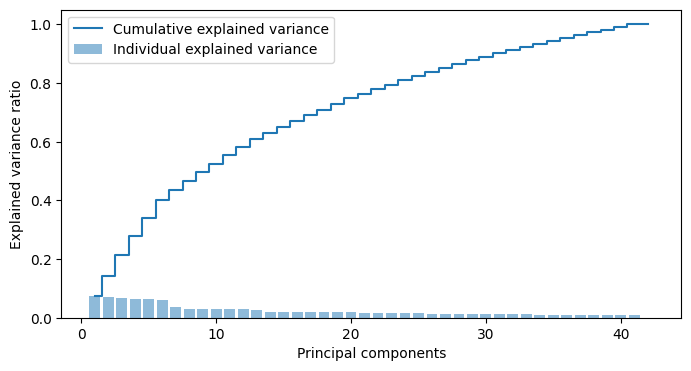

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
pca = PCA(n_components=42)
X_pca = pca.fit_transform(X_scaled)
explained_variance_ratio = pca.explained_variance_ratio_

feature_counts = {'80%': None, '85%': None, '90%': None, '95%': None}
total_variance = 0

# This will calculate how many principal components we need to maintain different percentages of our information.
for i, ratio in enumerate(explained_variance_ratio):
    total_variance += ratio
    for threshold in feature_counts:
        if feature_counts[threshold] is None and total_variance >= float(threshold.strip('%')) / 100:
            feature_counts[threshold] = i + 1  # Add 1 to convert from 0-based index to count of features
            break

print("Number of features needed to maintain:")
for threshold, count in feature_counts.items():
    print(f"{threshold} of the original information:", count)

plt.figure(figsize=(8, 4))
plt.bar(range(1, 43), pca.explained_variance_ratio_, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, 43), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')

We now needed to get some baseline results to compare our experiments against. We ran tests for a range of poly kernel degrees as well as the gamma=["auto", "scale"] values for rbf kernels. In the section below, we start with a full, unmodified data run for an absolute baseline and then start comparing those results with the accuracy achieved when we run the same models using different levels of principal components. Our goal here was to assess what would be a reasonable trade off between reduced accuracy compared to time savings for using lower amounts of principal components.

In [ ]:
pca_components = [None, 36, 31, 27, 24]  # None represents the original training data
results_baseline = defaultdict(dict)
total_time_per_component = []

for components in pca_components:
    component_start_time = time.time()

    if components is not None:
        print(f"\nFollowing results use {components} principal components:")
        pca = PCA(n_components=components)
        X_train_pca = pca.fit_transform(X_train_full)
        X_val_pca = pca.transform(X_val)
        X_new_train = X_train_pca
        X_new_val = X_val_pca
    else:
        print("Following results use the original data (no PCA).")
        X_new_train = X_train_full
        X_new_val = X_val

    poly_results = defaultdict(tuple)

    for degree in range(2, 7):
        svc_poly = svm.SVC(kernel='poly', degree=degree, C=1.0, coef0=0.0, class_weight='balanced')
        svc_poly.fit(X_new_train, y_train_full)
        y_pred_poly = svc_poly.predict(X_new_val)
        report = classification_report(y_val, y_pred_poly)
        balanced_accuracy = balanced_accuracy_score(y_val, y_pred_poly)
        poly_results[degree] = (balanced_accuracy, report)
        print(f"Balanced accuracy for {degree} degree: {balanced_accuracy:.4f}")

    rbf_results = defaultdict(tuple)
    gamma_values = ["auto", "scale"]

    for gamma in gamma_values:
        svc_rbf = svm.SVC(kernel='rbf', C=1.0, gamma=gamma, class_weight='balanced')
        svc_rbf.fit(X_new_train, y_train_full)
        y_pred_rbf = svc_rbf.predict(X_new_val)
        report = classification_report(y_val, y_pred_rbf)
        balanced_accuracy = balanced_accuracy_score(y_val, y_pred_rbf)
        rbf_results[gamma] = (balanced_accuracy, report)
        print(f"Balanced accuracy for {gamma} as gamma value: {balanced_accuracy:.4f}")

    results_baseline[components] = {'poly': poly_results, 'rbf': rbf_results}

    elapsed_time = time.time() - component_start_time
    total_time_per_component.append(elapsed_time)
    minutes, seconds = divmod(elapsed_time, 60)
    print(f"Total time for components {components}: {int(minutes)}m {seconds:.1f}s")


Following results use the original data (no PCA).
Balanced accuracy for 2 degree: 0.6009
Balanced accuracy for 3 degree: 0.6137
Balanced accuracy for 4 degree: 0.6049
Balanced accuracy for 5 degree: 0.5653
Balanced accuracy for 6 degree: 0.5160
Balanced accuracy for auto as gamma value: 0.6578
Balanced accuracy for scale as gamma value: 0.6575
Total time for components None: 37m 33.8s

Following results use 36 principal components:
Balanced accuracy for 2 degree: 0.5696
Balanced accuracy for 3 degree: 0.5840
Balanced accuracy for 4 degree: 0.5796
Balanced accuracy for 5 degree: 0.5394
Balanced accuracy for 6 degree: 0.5041
Balanced accuracy for auto as gamma value: 0.6331
Balanced accuracy for scale as gamma value: 0.6281
Total time for components 36: 30m 19.2s

Following results use 31 principal components:
Balanced accuracy for 2 degree: 0.5498
Balanced accuracy for 3 degree: 0.5658
Balanced accuracy for 4 degree: 0.5636
Balanced accuracy for 5 degree: 0.5281
Balanced accuracy for 6 

Below is simply some code to set up a table for easy comparison of these output values above.

In [ ]:
baseline_info = None

# Below is for setting up a table to compare our accuracy loss and time savings
print()
print("{:<10} {:<20} {:<20} {:<20} {:<20}".format('PCA Comp', 'Avg Accuracy', 'Acc Diff', 'Time (s)', '% of Baseline Time'))
for i, components in enumerate(pca_components):
    accuracies = [result[0] for result_dict in results_baseline[components].values() for result in result_dict.values()]
    avg_accuracy = np.mean(accuracies)
    time_for_components = total_time_per_component[i]

    if components is None:
        accuracy_diff = 0
        time_percentage = 100
        baseline_info = (avg_accuracy, time_for_components)
    else:
        baseline_avg_accuracy = baseline_info[0]
        accuracy_diff = avg_accuracy - baseline_avg_accuracy
        time_percentage = (time_for_components / baseline_info[1]) * 100

    print("{:<10} {:<20.4f} {:<20.4f} {:<20.1f} {:<20.1f}%".format(
        'None' if components is None else components,
        avg_accuracy,
        accuracy_diff,
        time_for_components,
        time_percentage
    ))


PCA Comp   Avg Accuracy         Acc Diff             Time (s)             % of Baseline Time  
None       0.6023               0.0000               2253.8               100.0               %
36         0.5769               -0.0255              1819.2               80.7                %
31         0.5601               -0.0422              2047.8               90.9                %
27         0.5442               -0.0581              1861.4               82.6                %
24         0.5273               -0.0750              1756.8               77.9                %



PCA Comp   Avg Accuracy         Acc Diff             Time (s)             % of Baseline Time  
None       0.6023               0.0000               983.8                100.0               %  
36         0.5769               -0.0255              828.4                84.2                %  
31         0.5602               -0.0421              799.7                81.3                %  
27         0.5471               -0.0552              777.5                79.0                %  
24         0.5241               -0.0782              786.7                80.0  

RETURN TO THIS CELL, PUT A SCREENSHOT OF THE TABLE ABOVE IN SO IT'S NOT IMPOSSIBLE TO READ.

We would like to note that the majority of SVM testing was done on one of our laptops and that the results you see in the cell above do not match what consistently happened in that environment. This Final_Report notebook is made up of code transferred as we polished it up and we ran it using Google's Colab environment for the sake of showing you what the output looks like but we did not anticipate how frequently Colab would disconnect and how varied the time metrics would be in said environment so please forgive us for that inconsistency.

Below you will see an image [INSERT TABLE IMAGE FROM ABOVE BELOW] that reflects what we saw during testing. You can see that using 31 principal components, we can save about ~19% of our time in exchange for a straight loss of 4.21% to our averaged balanced accuracy. At 31 PCs, we retain 90% of our original information and the aforementioned tradeoff seemed to be the most reasonable of the options available as we knew we wanted to give ourselves a little more accuracy wiggle room for when we experimented with reduced datasets. It's hard to truly discern how much using PCA will skew the results when doing the final testing of the hyperparameters on the full dataset but we figured, given the low stakes of Connect 4, staying within a single digit territory of accuracy loss would be acceptable for the sake of time saving.

In the cell below, we have some code that will give us the average accuracy of each poly degree and each rbf gamma value across the different principal component levels. We thought narrowing our search down to the 5 highest performing models would help us save time in future parameter testing and we knew from our experimenting in plain accuracy that poly degrees of 6 and 7 did not perform well in addition to taking a drastically longer amount of time to train. From our results below, you will see that we have moved the following models onward for further experimenting: poly models using degrees 2, 3, and 4; rbf models using gamma values of "scale" and "auto". We do use the 5 and 6 model one more time in the code cell that starts with "percent_of_training_data..." not too far below because we wanted to be sure the accuracy average in that section was directly comparable to this section above.

In [ ]:
poly_accuracies = defaultdict(list)
rbf_accuracies = defaultdict(list)

for pca_comp, result_dict in results_baseline.items():
    poly_results = result_dict['poly']
    rbf_results = result_dict['rbf']

    for degree, values in poly_results.items():
        balanced_accuracy = values[0]
        poly_accuracies[degree].append(balanced_accuracy)

    for gamma, values in rbf_results.items():
        balanced_accuracy = values[0]
        rbf_accuracies[gamma].append(balanced_accuracy)

print("Avg Balanced Accuracies for 'Poly' Kernels:")
for degree, accuracies in poly_accuracies.items():
    average_accuracy = sum(accuracies) / len(accuracies)
    print(f"Degree {degree}: {average_accuracy:.4f}")

print("\nAvg Balanced Accuracies for 'RBF' Kernels:")
for gamma, accuracies in rbf_accuracies.items():
    average_accuracy = sum(accuracies) / len(accuracies)
    print(f"Gamma {gamma}: {average_accuracy:.4f}")

Avg Balanced Accuracies for 'Poly' Kernels:
Degree 2: 0.5499
Degree 3: 0.5637
Degree 4: 0.5653
Degree 5: 0.5293
Degree 6: 0.4941

Avg Balanced Accuracies for 'RBF' Kernels:
Gamma auto: 0.6179
Gamma scale: 0.6108


For thoroughness, we used the code below to test a "sigmoid" kernel as well as a LinearSVC model. Considering these models are better suited to binary classifications and not our 3 class problem, we did not expect any impressive results and our test below confirms that they are indeed handily outcompeted by the models we moved ahead from the section above. With these poor preliminary results, we did not opt to experiment further with the 2 models below.

In [ ]:
svc_sigmoid = svm.SVC(kernel='sigmoid', gamma='auto', coef0=1, class_weight='balanced')
svc_sigmoid.fit(X_train_full, y_train_full)
y_pred_sigmoid_val = svc_sigmoid.predict(X_val)
print("Validation Balanced Accuracy (Sigmoid):", balanced_accuracy_score(y_val, y_pred_sigmoid_val))
y_pred_sigmoid_test = svc_sigmoid.predict(X_test)
print("Test Balanced Accuracy (Sigmoid):", balanced_accuracy_score(y_test, y_pred_sigmoid_test))

n_samples, n_features = X_train_full.shape
svc_linear = svm.LinearSVC(random_state=5, dual=n_samples > n_features, class_weight='balanced')
svc_linear.fit(X_train_full, y_train_full)
y_pred_linear_val = svc_linear.predict(X_val)
print("Validation Balanced Accuracy (LinearSVC):", balanced_accuracy_score(y_val, y_pred_linear_val))
y_pred_linear_test = svc_linear.predict(X_test)
print("Test Balanced Accuracy (LinearSVC):", balanced_accuracy_score(y_test, y_pred_linear_test))

Validation Balanced Accuracy (Sigmoid): 0.33073546850770585
Test Balanced Accuracy (Sigmoid): 0.34752973240260226
Validation Balanced Accuracy (LinearSVC): 0.39752494573185726
Test Balanced Accuracy (LinearSVC): 0.3501545638621469


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In the cell below, we are performing some further experimentation to see how much farther we can reduce the size of our dataset while still retaining a reasonable accuracy in comparison to the full, unmodified dataset. We ran this data set with all the same models as the PCA test for the sake of direct comparison. These models are all being run using the 31 PCs we decided on from our test above.

In [ ]:
percent_of_training_data = [1.0, 0.75, .5, .25]
results_31_pca = defaultdict(dict)
total_time_per_percentage = []

pca = PCA(n_components=31)
X_train_pca = pca.fit_transform(X_train_full)
X_val_pca = pca.transform(X_val)

for percentage in percent_of_training_data:
    print(f"\nTraining with {percentage * 100}% of data:")
    percentage_start_time = time.time()

    if percentage < 1.0:
        X_train_subset, X_discard, y_train_subset, y_discard = train_test_split(
            X_train_pca, y_train_full, test_size=1-percentage, random_state=5, stratify=y_train_full)
    else:
        X_train_subset = X_train_pca
        y_train_subset = y_train_full

    poly_results = defaultdict(tuple)

    for degree in range(2, 7):
        svc_poly = svm.SVC(kernel='poly', degree=degree, C=1.0, coef0=0.0, class_weight='balanced')
        svc_poly.fit(X_train_subset, y_train_subset)
        y_pred_poly = svc_poly.predict(X_val_pca)
        balanced_accuracy = balanced_accuracy_score(y_val, y_pred_poly)
        poly_results[degree] = balanced_accuracy
        print(f"Balanced accuracy for {degree} degree: {balanced_accuracy:.4f}")

    rbf_results = defaultdict(tuple)
    gamma_values = ["auto", "scale"]
    for gamma in gamma_values:
        svc_rbf = svm.SVC(kernel='rbf', C=1.0, gamma=gamma, class_weight='balanced')
        svc_rbf.fit(X_train_subset, y_train_subset)
        y_pred_rbf = svc_rbf.predict(X_val_pca)
        balanced_accuracy = balanced_accuracy_score(y_val, y_pred_rbf)
        rbf_results[gamma] = balanced_accuracy
        print(f"Balanced accuracy for {gamma} as gamma value: {balanced_accuracy:.4f}")

    results_31_pca[percentage] = {'poly': poly_results, 'rbf': rbf_results}

    elapsed_time = time.time() - percentage_start_time
    total_time_per_percentage.append(elapsed_time)
    minutes, seconds = divmod(elapsed_time, 60)
    print(f"Total time for {percentage * 100}% of data: {int(minutes)}m {seconds:.1f}s")



baseline_info = None

#Creation of comparison table below, very similar to PCA table farther above
print()
print("{:<15} {:<20} {:<20} {:<20} {:<20}".format('Data %', 'Avg Accuracy', 'Acc Diff', 'Time (s)', '% of Baseline Time'))
for i, percentage in enumerate(percent_of_training_data):
    accuracies = [acc for kernel_results in results_31_pca[percentage].values() for acc in kernel_results.values()]
    avg_accuracy = np.mean(accuracies)
    time_for_percentage = total_time_per_percentage[i]

    if percentage == 1.0:
        accuracy_diff = 0
        time_percentage = 100
        baseline_info = (avg_accuracy, time_for_percentage)
    else:
        full_data_avg_accuracy = baseline_info[0]
        accuracy_diff = avg_accuracy - full_data_avg_accuracy
        time_percentage = (time_for_percentage / baseline_info[1]) * 100

    print("{:<15} {:<20.4f} {:<20.4f} {:<20.1f} {:<20.1f}%".format(
        f"{percentage * 100}%",
        avg_accuracy,
        accuracy_diff,
        time_for_percentage,
        time_percentage
    ))


Training with 100.0% of data:
Balanced accuracy for 2 degree: 0.5498
Balanced accuracy for 3 degree: 0.5658
Balanced accuracy for 4 degree: 0.5636
Balanced accuracy for 5 degree: 0.5281
Balanced accuracy for 6 degree: 0.4913
Balanced accuracy for auto as gamma value: 0.6141
Balanced accuracy for scale as gamma value: 0.6085
Total time for 100.0% of data: 35m 46.4s

Training with 75.0% of data:
Balanced accuracy for 2 degree: 0.5417
Balanced accuracy for 3 degree: 0.5591
Balanced accuracy for 4 degree: 0.5518
Balanced accuracy for 5 degree: 0.5135
Balanced accuracy for 6 degree: 0.4754
Balanced accuracy for auto as gamma value: 0.5980
Balanced accuracy for scale as gamma value: 0.5952
Total time for 75.0% of data: 18m 0.7s

Training with 50.0% of data:
Balanced accuracy for 2 degree: 0.5384
Balanced accuracy for 3 degree: 0.5338
Balanced accuracy for 4 degree: 0.5345
Balanced accuracy for 5 degree: 0.4900
Balanced accuracy for 6 degree: 0.4541
Balanced accuracy for auto as gamma value:

While these numbers above are not quite the same ones we were working with on a local laptop environment, they still hold up for demonstrating the justification for our next decision. As a reminder, the original full dataset (no PCA) had an average accuracy of 0.6023 and required 2253.8 s to finish training (Colab run, not laptop). With these numbers in mind, we chose to use 50% of the training data with 31 PCs as the future data configuration for further experimentation. This results in a loss of 7.24% accuracy but it allows us to experiment with different hyperparameters using only ~21.4% of the time we otherwise would have needed.

Below this is a cell with code to calculate the effect on accuracy that different numbers of stratified kfolds have and also the amount of time it takes.



In [ ]:
X_train_kfold, X_discard, y_train_kfold, y_discard = train_test_split(
    X_train_full, y_train_full, test_size=0.5, random_state=5, stratify=y_train_full)

pca = PCA(n_components=31)
X_train_pca = pca.fit_transform(X_train_kfold)

results_kfold = defaultdict(lambda: defaultdict(list))
elapsed_times = []
folds = [3,5,10]

for fold_num in folds:
    start_time = time.time()
    skf = StratifiedKFold(n_splits=fold_num, shuffle=True, random_state=5)
    for degree in range(2, 5):
        accuracies = []
        for train_index, test_index in skf.split(X_train_pca, y_train_kfold):
            X_train_fold = X_train_pca[train_index]
            X_test_fold = X_train_pca[test_index]
            y_train_fold = y_train_kfold[train_index]
            y_test_fold = y_train_kfold[test_index]

            svc_poly = svm.SVC(kernel='poly', degree=degree, C=1.0, coef0=0, class_weight='balanced')
            svc_poly.fit(X_train_fold, y_train_fold)
            y_pred_poly = svc_poly.predict(X_test_fold)
            accuracy = balanced_accuracy_score(y_test_fold, y_pred_poly)
            accuracies.append(accuracy)

        results_kfold[fold_num]['poly'].append((degree, np.mean(accuracies)))

    gamma_values = ["auto", "scale"]
    for gamma in gamma_values:
        accuracies = []
        for train_index, test_index in skf.split(X_train_pca, y_train_kfold):
            X_train_fold = X_train_pca[train_index]
            X_test_fold = X_train_pca[test_index]
            y_train_fold = y_train_kfold[train_index]
            y_test_fold = y_train_kfold[test_index]

            svc_rbf = svm.SVC(kernel='rbf', C=1.0, gamma=gamma, class_weight='balanced')
            svc_rbf.fit(X_train_fold, y_train_fold)
            y_pred_rbf = svc_rbf.predict(X_test_fold)
            accuracy = balanced_accuracy_score(y_test_fold, y_pred_rbf)
            accuracies.append(accuracy)

        results_kfold[fold_num]['rbf'].append((gamma, np.mean(accuracies)))

    elapsed_time = time.time() - start_time
    elapsed_times.append(elapsed_time)
    minutes, seconds = divmod(elapsed_time, 60)
    print(f"For {fold_num} folds, elapsed time: {int(minutes)}m {int(seconds)}s")
    for kernel_type, results in results_kfold[fold_num].items():
        print(f"Kernel Type: {kernel_type}")
        for param, acc in results:
            print(f"Parameter: {param}, Balanced Accuracy: {acc:.4f}")

For 3 folds, elapsed time: 4m 50s
Kernel Type: poly
Parameter: 2, Balanced Accuracy: 0.5408
Parameter: 3, Balanced Accuracy: 0.5371
Parameter: 4, Balanced Accuracy: 0.5268
Kernel Type: rbf
Parameter: auto, Balanced Accuracy: 0.5859
Parameter: scale, Balanced Accuracy: 0.5825
For 5 folds, elapsed time: 10m 30s
Kernel Type: poly
Parameter: 2, Balanced Accuracy: 0.5456
Parameter: 3, Balanced Accuracy: 0.5403
Parameter: 4, Balanced Accuracy: 0.5411
Kernel Type: rbf
Parameter: auto, Balanced Accuracy: 0.5920
Parameter: scale, Balanced Accuracy: 0.5846
For 10 folds, elapsed time: 25m 16s
Kernel Type: poly
Parameter: 2, Balanced Accuracy: 0.5525
Parameter: 3, Balanced Accuracy: 0.5476
Parameter: 4, Balanced Accuracy: 0.5465
Kernel Type: rbf
Parameter: auto, Balanced Accuracy: 0.6003
Parameter: scale, Balanced Accuracy: 0.5921


For the 5 models we are continuing with (poly degrees 2, 3, 4 and rbf with gamma=['auto', 'scale']), the average accuracy from the no kfold section above this one for 50% data, 31 PCs was 0.553 (234 seconds - note, this number comes from unshown test where poly degrees 5 and 6 not trained so number is comparable to those below). Using a stratified kfold, we achieved the following average accuracies: 3 folds: 0.5545 (290 seconds); 5 folds: 0.5607 (630 seconds); 10 folds: 0.5678 (1516 seconds). This translates to: 3 folds: ~24% time increase for an accuracy increase of only 0.0015; 5 folds: ~270% more time for 0.0077; and 10 folds: ~650% more time for 0.0148.

We acknowledge that using a kfold value of 3 wouldn't have hurt search times too horribly and that it could lead to a more robust model but after all the time spent fumbling around with the plain accuracy experimentation, time was a little bit tighter near the end as finals loomed near. Lack of time combined with the fact that, again, predicting the outcome of a Connect 4 game is fairly low stakes, missing out on these tiny accuracy gains seemed like an acceptable sacrifice to speed up the hyperparameter search.



With the decision above to cut the time needed for kfold cross validation, we started searching for optimal hyperparameters using ParameterGrids below. We begin with our search through various poly hyperparameter configurations below. From here on, we make heavy use of saving configurations and their performance in json files as there was a painful process of discovery having things run overnight just to find that, although the majority was processed, the remaining models were taking far too long and the process had to be stopped thus resulting in quite a few large losses of time in the early experimentation phase. The code in the cell below is what was used to generate the data we are about to share but, given the time it took to process the info in the first place and the time/connection inconsistency on Colab, we will use another cell below the following cell to load previously made jsons on the local laptop environment and discuss the results further there. The cell below has been run with 1/30th the data on Colab for the saking of demonstrating functionality. The code to print out the results in order is a few cells down.

In [ ]:
# Can adjust the test size to configure how much of our 70% training data is thrown away
# for the sake of testing this faster with less data.
X_train, X_discard, y_train, y_discard = train_test_split(
    X_train_full, y_train_full, test_size=29/30, random_state=5, stratify=y_train_full)

pca = PCA(n_components=31)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# Below are the variations of grids we experimented, more discussion beyond this cell.
#1/30th grid
poly_param_grid = {
    'C': [0.1, 1, 10, 100],
    'class_weight': ['balanced'],
    'coef0': [0.0, 1.0, 3.0, 10.0],
    'degree': [2, 3, 4],
    'kernel': ['poly']
}

# #1/20th grid
# poly_param_grid = {
#     'C': [1, 10, 100],
#     'class_weight': ['balanced'],
#     'coef0': [1.0, 3.0, 10.0],
#     'degree': [2, 3, 4],
#     'kernel': ['poly']
# }

# #1/10th grid
# poly_param_grid = {
#     'C': [1, 10, 100],
#     'class_weight': ['balanced'],
#     'coef0': [1.0, 3.0, 10.0],
#     'degree': [3, 4],
#     'kernel': ['poly']
# }

# #1/2 grid
# poly_param_grid = {
#     'C': [1, 10, 50],
#     'class_weight': ['balanced'],
#     'coef0': [1.0, 3.0, 10.0],
#     'degree': [3, 4],
#     'kernel': ['poly']
# }

poly_results = []
runCount = 0
save_path = 'svm_poly_results_throwaway.json' #Rename this based on percentage of data used
total_permutations = len(list(ParameterGrid(poly_param_grid)))

for params in ParameterGrid(poly_param_grid):
    print(f"Testing parameters: {params}")
    start_time = time.time()

    model = svm.SVC(**params)
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_val_pca)

    balanced_accuracy = balanced_accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True, zero_division=1)
    poly_results.append({
        'params': params,
        'balanced_accuracy': balanced_accuracy,
        'report': report
    })

    with open(save_path, 'w') as f:
        json.dump(poly_results, f, indent=4)
    elapsed_time = time.time() - start_time
    minutes, seconds = divmod(elapsed_time, 60)
    print(f"Elapsed time: {int(minutes)}m {seconds:.1f}s")

    runCount += 1
    runCountPercent = (runCount / total_permutations) * 100
    print(f"Done with {runCount} of {total_permutations}. We are (very) approximately {runCountPercent:.2f}% done")

poly_results.sort(key=lambda x: x['balanced_accuracy'], reverse=True)

Testing parameters: {'C': 0.1, 'class_weight': 'balanced', 'coef0': 0.0, 'degree': 2, 'kernel': 'poly'}
Elapsed time: 0m 0.7s
Done with 1 of 48. We are (very) approximately 2.08% done
Testing parameters: {'C': 0.1, 'class_weight': 'balanced', 'coef0': 0.0, 'degree': 3, 'kernel': 'poly'}
Elapsed time: 0m 0.6s
Done with 2 of 48. We are (very) approximately 4.17% done
Testing parameters: {'C': 0.1, 'class_weight': 'balanced', 'coef0': 0.0, 'degree': 4, 'kernel': 'poly'}
Elapsed time: 0m 0.6s
Done with 3 of 48. We are (very) approximately 6.25% done
Testing parameters: {'C': 0.1, 'class_weight': 'balanced', 'coef0': 1.0, 'degree': 2, 'kernel': 'poly'}
Elapsed time: 0m 0.6s
Done with 4 of 48. We are (very) approximately 8.33% done
Testing parameters: {'C': 0.1, 'class_weight': 'balanced', 'coef0': 1.0, 'degree': 3, 'kernel': 'poly'}
Elapsed time: 0m 0.6s
Done with 5 of 48. We are (very) approximately 10.42% done
Testing parameters: {'C': 0.1, 'class_weight': 'balanced', 'coef0': 1.0, 'degre

Despite all the testing to find what we thought would be a reasonable amount of data to work with for the ParameterGrid (50% data, 31 PCs), we were unfortunately blindsided by some wildly time intensive models that caused us to have to abandon some early runs. In the early plain accuracy runs, 6 and 7 degree poly kernels took an absurd amount of time and we also found that, for poly models, a C value of 100 or higher and coef0 values of 25 or higher led to extremely long training times even at 1/10th our full dataset. This lead to a more iterative exploration with smaller datasets so that when we finally spent the large amount of time necessary for a larger portion of the data, that effort would be focused on a range of parameters that would be more likely to be successful compared to the wider, and blinder, net of hyperparameters being cast at the beginning of experimentation. We did continue to use 31 PCs throughout this part of the process.

Once the code above was done training/assessing the models, the code below would be used to evaluate if certain parameters were worth continuing to explore. In the cell above, you can see the original ParameterGrid that we began exploring at 1/30th the full dataset. Using the code below, we can assess how many times a parameter landed in the top 50% of solutions. Here is the full printout for 1/30th the data:

Parameter: C  
C=0.1: 25.00% of permutations in top 50%  
C=1: 50.00% of permutations in top 50%  
C=10: 75.00% of permutations in top 50%  
C=100: 58.33% of permutations in top 50%  

Parameter: coef0  
coef0=0.0: 0.00% of permutations in top 50%  
coef0=1.0: 50.00% of permutations in top 50%  
coef0=3.0: 75.00% of permutations in top 50%  
coef0=10.0: 83.33% of permutations in top 50%  

Parameter: degree  
degree=2: 37.50% of permutations in top 50%  
degree=3: 56.25% of permutations in top 50%  
degree=4: 62.50% of permutations in top 50%  

In the beginning ParameterGrid, each C value can have a total of 12 different permutations for any given C value. What the results above are saying for C=0.1, for example, is that only 3 out of the 12 combinations (25%) were good enough to land them in the top 50% of parameter configurations sorted by accuracy. The results above were enough for us to justify removing C=0.1 and coef0=0.0. We removed these from the ParameterGrid and continued exploring larger portions of the data. If you wish to view all of the info for each amount of data, feel free to change the json file name in the code below. For brevity, we will only show the worst performing parameters for the rest of this discussion to justify why we made the decisions we did.

1/20th data:  
degree=2: 11.11% of permutations in top 50%
2nd degree removed from grid.
All other parameters: 44.44% or more in top 50%.

1/10th data:  
C=1: 33.33% of permutations in top 50% was the lowest value. Not quite low enough for us to consider elimination so we looked in top 33% of solutions and found that C=100 drops from 50% in the top 50% to just 16.67% in the top 33%. This, to us, suggested a higher C value could potentially be useful but perhaps C=100 is overshooting it so we changed that 100 to 50 for the final 1/2 data run since that would put it a bit closer to our more successful numbers.

We can see the final experimentation outcome with 1/2 the data for the poly kernels printed out by the code cell beyond the one below.

In [ ]:
# folder_path = '/content/drive/My Drive/Experimentation Results/'
# file_path = folder_path + 'svm_poly_results_half.json'
# with open(file_path, 'r') as file:
#     poly_results = json.load(file)
# The above is for the sake of getting some useful output saved to this document
# by putting the documents in my google drive.
# REMOVE BEFORE TURNING IN AS IT WON'T WORK FOR OTHERS
# Json loading below should work fine provided we put the jsons in the
# correct folder with the notebook before turning in. Must test.


# Please note that you will need to uncomment the poly_param_grid above that corresponds to the
# json file you are loading if you want the # Calculate percentage section below to work as intended.
with open('svm_poly_results_throwaway.json', 'r') as f:
    poly_results = json.load(f)

poly_results.sort(key=lambda x: x['balanced_accuracy'], reverse=True)

total_counts = defaultdict(int)
top_counts = defaultdict(int)

# Determine the counts of each parameter in the top X% of configurations by balanced accuracy
top_indices_stop_index = int(len(poly_results) * 0.5)

# Count instances of parameter
for i, result in enumerate(poly_results):
    for param, value in result['params'].items():
        if param in ['kernel', 'class_weight']:
            continue
        param_value_key = f'{param}_{value}'
        total_counts[param_value_key] += 1
        if i <= top_indices_stop_index:
            top_counts[param_value_key] += 1

# Calculate percentage
for param in ['C', 'coef0', 'degree']:
    print(f"\nParameter: {param}")
    for value in poly_param_grid[param]:
        param_value_key = f'{param}_{value}'
        if total_counts[param_value_key] > 0:
            percentage_in_top_third = (top_counts[param_value_key] / total_counts[param_value_key]) * 100
            print(f"{param}={value}: {percentage_in_top_third:.2f}% of permutations in top 50%")


Parameter: C
C=0.1: 25.00% of permutations in top 50%
C=1: 50.00% of permutations in top 50%
C=10: 75.00% of permutations in top 50%
C=100: 58.33% of permutations in top 50%

Parameter: coef0
coef0=0.0: 0.00% of permutations in top 50%
coef0=1.0: 50.00% of permutations in top 50%
coef0=3.0: 75.00% of permutations in top 50%
coef0=10.0: 83.33% of permutations in top 50%

Parameter: degree
degree=2: 37.50% of permutations in top 50%
degree=3: 56.25% of permutations in top 50%
degree=4: 62.50% of permutations in top 50%


The cell below can be used to print the final sorted results of the best parameters found in the grid search above. We have run the cell below with the final results of the 50% data run so you can see the top contenders for the poly kernels. There is one permutation missing (C=50, coef0=10, degree=4) below unfortunately. This was one of those instances where the model was taking an unexpectedly very long time to train and the laptop needed to be shut off before it could finish. For the sake of time, we had to move on without the knowledge of accuracy for that particular permutation.

Beyond the cell below, we are going to repeat the same process except for the rbf models.

In [ ]:
folder_path = '/content/drive/My Drive/Experimentation Results/'
file_path = folder_path + 'svm_poly_results_half.json'
with open(file_path, 'r') as file:
    poly_results = json.load(file)
# The above is for the sake of getting some useful output saved to this document
# by putting the documents in my google drive.
# REMOVE BEFORE TURNING IN AS IT WON'T WORK FOR OTHERS
# Json loading below should work fine provided we put the jsons in the
# correct folder with the notebook before turning in. Must test.

# with open('svm_poly_results_throwaway.json', 'r') as f:
#     poly_results = json.load(f)

poly_results.sort(key=lambda x: x['balanced_accuracy'], reverse=True)

first_result = True
index = 1
for result in poly_results:
    if first_result:
        print(f"\nBest parameters: {result['params']}")
        print(f"Best Combination Balanced Accuracy: {result['balanced_accuracy']:.3f}")
        first_result = False
        index += 1
    else:
        print(f"The #{index} best option")
        print(result['params'])
        print(f"Balanced Acc: {result['balanced_accuracy']:.3f}")
        index += 1


Best parameters: {'C': 50, 'class_weight': 'balanced', 'coef0': 3.0, 'degree': 4, 'kernel': 'poly'}
Best Combination Balanced Accuracy: 0.639
The #2 best option
{'C': 1, 'class_weight': 'balanced', 'coef0': 10.0, 'degree': 4, 'kernel': 'poly'}
Balanced Acc: 0.639
The #3 best option
{'C': 10, 'class_weight': 'balanced', 'coef0': 10.0, 'degree': 3, 'kernel': 'poly'}
Balanced Acc: 0.638
The #4 best option
{'C': 10, 'class_weight': 'balanced', 'coef0': 10.0, 'degree': 4, 'kernel': 'poly'}
Balanced Acc: 0.637
The #5 best option
{'C': 1, 'class_weight': 'balanced', 'coef0': 3.0, 'degree': 4, 'kernel': 'poly'}
Balanced Acc: 0.637
The #6 best option
{'C': 10, 'class_weight': 'balanced', 'coef0': 3.0, 'degree': 3, 'kernel': 'poly'}
Balanced Acc: 0.636
The #7 best option
{'C': 50, 'class_weight': 'balanced', 'coef0': 3.0, 'degree': 3, 'kernel': 'poly'}
Balanced Acc: 0.636
The #8 best option
{'C': 10, 'class_weight': 'balanced', 'coef0': 3.0, 'degree': 4, 'kernel': 'poly'}
Balanced Acc: 0.636
Th

Below we have the code used to generate our rbf kernel jsons. Further discussion below in similar format as above.

In [ ]:
X_train_pca, X_discard, y_train, y_discard = train_test_split(
    X_train_full, y_train_full, test_size=19/20, random_state=5, stratify=y_train_full)

pca = PCA(n_components=31)
X_train_pca = pca.fit_transform(X_train_pca)
X_val_pca = pca.transform(X_val)

#1/20th grid
rbf_param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}

# #1/10th grid
# rbf_param_grid = {
#     'C': [1, 10, 100],
#     'gamma': ['scale', 'auto', 0.1, 0.01],
#     'kernel': ['rbf'],
#     'class_weight': ['balanced']
# }

# #1/2 grid
# rbf_param_grid = {
#     'C': [10, 100],
#     'gamma': ['scale', 'auto', 0.01],
#     'kernel': ['rbf'],
#     'class_weight': ['balanced']
# }

rbf_results = []
runCount = 0
save_path = 'svm_rbf_results_throwaway.json'
total_permutations = len(list(ParameterGrid(rbf_param_grid)))

for params in ParameterGrid(rbf_param_grid):
    print(f"Testing parameters: {params}")
    start_time = time.time()
    model = svm.SVC(**params)
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_val_pca)
    balanced_acc = balanced_accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True, zero_division=1)
    rbf_results.append({
        'params': params,
        'balanced_accuracy': balanced_acc,
        'report': report
    })

    with open(save_path, 'w') as f:
        json.dump(rbf_results, f, indent=4)
    elapsed_time = time.time() - start_time
    minutes, seconds = divmod(elapsed_time, 60)
    runCount += 1
    runCountPercent = (runCount / total_permutations) * 100
    print(f"Elapsed time: {int(minutes)}m {int(seconds)}s")
    print(f"Done with {runCount} of {total_permutations}. We are (very) approximately {runCountPercent:.2f}% done.")


rbf_results.sort(key=lambda x: x['balanced_accuracy'], reverse=True)

Testing parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Elapsed time: 0m 1s
Done with 1 of 20. We are (very) approximately 5.00% done.
Testing parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}
Elapsed time: 0m 1s
Done with 2 of 20. We are (very) approximately 10.00% done.
Testing parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}
Elapsed time: 0m 1s
Done with 3 of 20. We are (very) approximately 15.00% done.
Testing parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf'}
Elapsed time: 0m 1s
Done with 4 of 20. We are (very) approximately 20.00% done.
Testing parameters: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.001, 'kernel': 'rbf'}
Elapsed time: 0m 1s
Done with 5 of 20. We are (very) approximately 25.00% done.
Testing parameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Elapsed time: 0m 1s
Done with 6 of 20. We are (ve

The code cell below operates extremely similarly to poly equivalent above so not much to discuss in that regard. Let's take a look at some of the decisions that runs with different amounts of data resulted in.

1/20th data:  
Both C=0.1 and gamma=0.001 had 0% representation in the top 50% of combinations. Eash choice to remove these parameters.

1/10th data:  
C=1 had 0% representation in the top 50% and was also removed. Wanted to see if we could justify removing just one more parameter so we narrowed our search to the top 25% of combinations where gamma=0.1 had 0% representation. Removed this parameter as well.

We can see the final experimentation outcome with 1/2 the data for the rbf kernels printed out by the code cell beyond the one below.

In [ ]:
folder_path = '/content/drive/My Drive/Experimentation Results/'
file_path = folder_path + 'svm_rbf_results_1_20th.json'
with open(file_path, 'r') as file:
    rbf_results = json.load(file)
# The above is for the sake of getting some useful output saved to this document
# by putting the documents in my google drive.
# REMOVE BEFORE TURNING IN AS IT WON'T WORK FOR OTHERS
# Json loading below should work fine provided we put the jsons in the
# correct folder with the notebook before turning in. Must test.

# with open('svm_rbf_results_1_20th.json', 'r') as f:
#     rbf_results = json.load(f)

rbf_results.sort(key=lambda x: x['balanced_accuracy'], reverse=True)

total_counts = defaultdict(int)
top_counts = defaultdict(int)

# Define the top X% threshold index
top_indices_stop_index = int(len(rbf_results) * 0.50)

# Count instances of parameter
for i, result in enumerate(rbf_results):
    for param, value in result['params'].items():
        if param == 'kernel':
            continue
        value_key = f'{param}_{value}'
        total_counts[value_key] += 1
        if i <= top_indices_stop_index:
            top_counts[value_key] += 1

# Calculate percentage
for param, values in rbf_param_grid.items():
    if param == 'kernel' or param == 'class_weight':
        continue
    print(f"\nParameter: {param}")
    for value in values:
        value_key = f'{param}_{value}'
        if total_counts[value_key] > 0:
            percentage = (top_counts[value_key] / total_counts[value_key]) * 100
            print(f"{param}={value}: {percentage:.2f}% of permutations using this param in top 50%")


Parameter: C
C=0.1: 0.00% of permutations using this param in top 50%
C=1: 60.00% of permutations using this param in top 50%
C=10: 80.00% of permutations using this param in top 50%
C=100: 80.00% of permutations using this param in top 50%

Parameter: gamma
gamma=scale: 75.00% of permutations using this param in top 50%
gamma=auto: 75.00% of permutations using this param in top 50%
gamma=0.1: 75.00% of permutations using this param in top 50%
gamma=0.01: 50.00% of permutations using this param in top 50%
gamma=0.001: 0.00% of permutations using this param in top 50%


Below we have the code to print our ParameterGrid final results for our 50% data experiment for rbf.

In [ ]:
folder_path = '/content/drive/My Drive/Experimentation Results/'
file_path = folder_path + 'svm_rbf_results_half.json'
with open(file_path, 'r') as file:
    rbf_results = json.load(file)
# The above is for the sake of getting some useful output saved to this document
# by putting the documents in my google drive.
# REMOVE BEFORE TURNING IN AS IT WON'T WORK FOR OTHERS
# Json loading below should work fine provided we put the jsons in the
# correct folder with the notebook before turning in. Must test.

# with open('svm_rbf_results_1_20th.json', 'r') as f:
#     rbf_results = json.load(f)

rbf_results.sort(key=lambda x: x['balanced_accuracy'], reverse=True)

first_result = True
index = 1
for result in rbf_results:
    if first_result:
        print(f"\nBest parameters: {result['params']}")
        print(f"Best Combination Balanced Accuracy: {result['balanced_accuracy']:.3f}")
        first_result = False
        index += 1
    else:
        print(f"The #{index} best option")
        print(result['params'])
        print(f"Balanced Acc: {result['balanced_accuracy']:.3f}")
        index += 1


Best parameters: {'C': 100, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Best Combination Balanced Accuracy: 0.641
The #2 best option
{'C': 100, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}
Balanced Acc: 0.638
The #3 best option
{'C': 100, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf'}
Balanced Acc: 0.637
The #4 best option
{'C': 10, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}
Balanced Acc: 0.631
The #5 best option
{'C': 10, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Balanced Acc: 0.630
The #6 best option
{'C': 10, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf'}
Balanced Acc: 0.597


While we now definitely had some promising combinations of hyperparameters, we had just done a really fascinating genetic algorithm assignment for another class and wanted to see if we could leverage that kind of structure to help us find further high performing hyperparameter combos. Before we dive into the nitty gritty of that, we wanted to have a better idea of what values "auto" and "scale" for gamma actually represented for our specific problem so that we could pick some additional similar but alternative values to explore since both of those gamma values typically perform well in general.

In the output below, we can see the values for our specific data when using 31 PCs. We already saw 0.01 was a well performing value above and with the information below, we opted to add 0.025 and 0.05 as starting search parameters as well.

In [ ]:
pca = PCA(n_components=31)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

n_samples_all, n_features_all = X_train_pca.shape
auto = 1 / n_features_all
print(f"Auto: {auto}")
scale = 1 / (n_features_all * np.var(X_train_pca, axis=0))
print(f"Scale: {scale}")
mean_scale_gamma = np.mean(scale)
print("Mean Scale Gamma:", mean_scale_gamma)

Auto: 0.03225806451612903
Scale: [0.00987422 0.01052967 0.01080061 0.01148157 0.01249186 0.01343583
 0.01892233 0.01937618 0.02303561 0.02434611 0.02574028 0.02700921
 0.03047033 0.03250493 0.03305156 0.03645451 0.04072587 0.04121029
 0.0431669  0.04541239 0.04676979 0.04943647 0.05238596 0.05667528
 0.05810447 0.05882341 0.06103426 0.06241538 0.06315527 0.06542864
 0.06678605]
Mean Scale Gamma: 0.037130814195091504


Below is the genetic algorithm we put together for searching for more fine tuner hyperparameters. It takes an extremely long time to run so we will have some discussion farther below about some of the jsons that resulted from running it with larger datasets. We were able to run rbf kernels at 50% of the population as they trained much faster than the poly kernels which we unfortunately had to limit to 15% of the training data due to time constraints. There was seemed to be quite an exponential increase in time needed to train high C and coef0 poly kernel models. Because of this, for poly kernels, we limited C to a max of 50 and coef0 to 20. Some of the low dataset percentages (like 2%) ended up with rbf models having C=300 to 400 so we limited rbf models to C=150 at max to avoid longer training times and also to avoid possibly trending towards a highly overfitting C value. We experimented quite extensively with various solutions to get the ideal output from this process and we will discuss that below the code below.

We think it would be best to just start with a broad overview of what the code below started with and we will talk about all the things that changed after the code. This code generates two populations of hyperparameter combinations based on two parameter grids (rbf and poly) much like the ParameterGrid searches we already did. Each combination represents an individual in the population and each population will maintain the same amount of individuals throughout the run. The rbf and poly kernel populations are kept apart throughout the process and each of them evolve within their own population. Once the initial populations are set up, the models are trained and each population is sorted starting with the best models first. For each population, we select parents equaling up to 25% of their kernel's total population. Starting with the best model, it has an 85% chance to be picked. Whether or not it was picked, we continue down the list of parents and each time a parent is picked, this starting 85% is multiplied by 85% until it bottoms out at 5%. This means the best models are generally picked but there is a possibility lower models will also get a chance to contribute.

Once the parents have been picked from a population, we then would pair them off and combine their parameter traits to create one offspring combination. This would involve randomly choosing from one of the two parents' traits or, if it made sense for a particular parameter, taking the average of both of them. All the children resulting from the parents pairing off would then be put through a mutate function that would have a random chance to very slightly increase/decrease any one (or potentially multiple) of their parameter values. There was also a chance to switch between "scale"/"auto" gamma values and hardcoded values that you can see in the rbf_param_grid or for poly kernels to increase/decrease degrees.

Once this process was done, the children models are all trained and then added to the population they came from. This population is then sorted again and the worst performing individuals are cut from the end of the list to maintain a stable population which helps prevent computational costs from going out of control with unchecked populations. This summarizes how the code began. We will put some brief in code comments below to give a brief overview of what each function does and we will discuss all the changes we had to make in the space below the codecell.



In [ ]:
#FIX RUN GENETIC ALGORITHM METHOD
#Fix tol in model_train method - just for poly

X_train, X_discard, y_train, y_discard = train_test_split(
    X_train_full, y_train_full, test_size=0.98, random_state=5, stratify=y_train_full)

pca = PCA(n_components=31)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)

# Both starting param_grids based off of what was successful in experiments farther above.
rbf_param_grid = {
    'C': [10, 40, 70, 100],
    'gamma': ['scale', 'auto', 0.01, 0.025, 0.05],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}

poly_param_grid = {
    'C': [0.3, 1, 10, 30],
    'coef0': [1.0, 7.0, 15.0],
    'degree': [3, 4],
    'kernel': ['poly'],
    'class_weight': ['balanced']
}

# # Dummy grid - for use when we wanted to focus on running code for just one of the kernel types
# rbf_param_grid = {
#     'C': [1],
#     'gamma': [0.01],
#     'kernel': ['rbf'],
#     'class_weight': ['balanced']
# }

# # Dummy grid
# poly_param_grid = {
#     'C': [0.001],
#     'coef0': [0.0],
#     'degree': [2],
#     'kernel': ['poly'],
#     'class_weight': ['balanced']
# }

# Create an individual for each hyperparameter permutation
def generate_population(rbf_param_grid, poly_param_grid):
    populations = {'poly': [], 'rbf': []}

    for params in ParameterGrid(rbf_param_grid):
        populations['rbf'].append(params)

    for params in ParameterGrid(poly_param_grid):
        populations['poly'].append(params)

    return populations

# Does exactly what the names says
def train_evaluate_single_model(params):
    start_time = time.time()
    model = svm.SVC(**params)
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_val_pca)
    balanced_acc = balanced_accuracy_score(y_val, y_pred)
    return {'params': params, 'balanced_accuracy': balanced_acc}

# This was an addition we made unfortunately quite late in the project timeline that helped
# greatly speed up processing time by parallelizing the model training.
def train_and_evaluate_models(populations):
    kernel_results = {}
    for kernel_type, param_list in populations.items():
        print(f"Training models for kernel: {kernel_type}")
        num_cores = multiprocessing.cpu_count() - 2
        results = Parallel(n_jobs=num_cores)(delayed(train_evaluate_single_model)(
            params) for params in param_list)
        sorted_results = sorted(results, key=lambda x: x['balanced_accuracy'], reverse=True)
        kernel_results[kernel_type] = sorted_results
    return kernel_results

# Simply generates a random permutation from the starting grids
def generate_random_individual(kernel_type, param_grids):
    params = param_grids[kernel_type]
    if kernel_type == 'rbf':
        return {
            'kernel': 'rbf',
            'C': random.choice(params['C']),
            'gamma': random.choice(params['gamma']),
            'class_weight': 'balanced'
        }
    elif kernel_type == 'poly':
        return {
            'kernel': 'poly',
            'C': random.choice(params['C']),
            'coef0': random.choice(params['coef0']),
            'degree': random.choice(params['degree']),
            'class_weight': 'balanced'
        }

# How we selected the, generally, best models from the population with room for variation
def select_parents(sorted_parents):
    fraction_to_pick = 0.25
    num_parents_to_select = int(len(sorted_parents) * fraction_to_pick)
    selected_parents = []
    selection_probability = 0.85

    # The best hyperparameter combos have a high, but not guaranteed chance to be
    # picked for parents of the next generation. Still chance for less optimal
    # parameters to be picked for the sake of diversity.
    for parent in sorted_parents:
        if len(selected_parents) < num_parents_to_select:
            if np.random.rand() < selection_probability:
                selected_parents.append(parent['params'])
                selection_probability *= 0.85
                if selection_probability < 0.05:
                    selection_probability = 0.05
        else:
            break

    # Generate a random individual based on the kernel type
    # Ensures there will always be some diversity in parent pool if it becomes filled
    # with too many variations on the same local optima configuration.
    kernel_type = sorted_parents[0]['params']['kernel']
    random_individual = generate_random_individual(kernel_type, param_grids)

    # Ensure we have even number of parents to pair off
    if len(selected_parents) % 2 == 0:
        selected_parents[-1] = random_individual
    else:
        selected_parents.append(random_individual)

    return selected_parents


# Creates a child combination made from the elements of its parents hyperparameters
def poly_crossover(parents):
    children = []
    for i in range(0, len(parents), 2):
        parent1 = parents[i]
        parent2 = parents[i + 1] if i + 1 < len(parents) else parents[0]

        child_params = {
            'C': (parent1['C'] + parent2['C']) / 2,
            'coef0': (parent1['coef0'] + parent2['coef0']) / 2,
            'degree': random.choice([parent1['degree'], parent2['degree']]),
            'kernel': 'poly',
            'class_weight': 'balanced'
        }
        children.append({'params': child_params})
    return children


# Both mutate functions feature "common" mutations that mutate hyperparamaters very slightly, a set of more
# extreme mutations that are more rare but affect the values even more, and finally the most rare but most
# extreme mutations that cause very large jumps in values.
def poly_mutate(children):
    for child in children:
        # Common but minor mutations
        if random.random() < 0.6:
            new_c = child['params']['C'] * (1 + 0.025 * random.choice([-1, 1]))
            child['params']['C'] = min(new_c, 50)
        if random.random() < 0.6:
            new_coef0 = child['params']['coef0'] * (1 + 0.025 * random.choice([-1, 1]))
            child['params']['coef0'] = min(new_coef0, 20)
        if random.random() < 0.3:
            new_degree = max(2, min(6, child['params']['degree'] + random.choice([-1, 1])))
            child['params']['degree'] = new_degree

        # Moderate mutations - more rare
        if random.random() < 0.3:
            new_c = child['params']['C'] * (1 + 0.25 * random.choice([-1, 1]))
            child['params']['C'] = min(new_c, 50)
        if random.random() < 0.3:
            new_coef0 = child['params']['coef0'] * (1 + 0.25 * random.choice([-1, 1]))
            child['params']['coef0'] = min(new_coef0, 20)
        if random.random() < 0.15:
            new_degree = max(2, min(6, child['params']['degree'] + random.choice([-2, 2])))
            child['params']['degree'] = new_degree
        if random.random() < 0.15:
            new_c = child['params']['C'] + 5
            child['params']['C'] = min(new_c, 50)

        # Extreme mutations - most rare
        if random.random() < 0.15:
            new_c = child['params']['C'] * (1 + 0.67 * random.choice([-1, 1]))
            child['params']['C'] = min(new_c, 50)  # Cap C
        if random.random() < 0.15:
            new_coef0 = child['params']['coef0'] * (1 + 0.67 * random.choice([-1, 1]))
            child['params']['coef0'] = min(new_coef0, 20)

        child['params']['class_weight'] = 'balanced'

    return children

# Creates a child combination made from the elements of its parents hyperparameters
def rbf_crossover(parents):
    children = []
    for i in range(0, len(parents), 2):
        parent1 = parents[i]
        parent2 = parents[i+1] if i+1 < len(parents) else parents[0]

        if isinstance(parent1['gamma'], str) or isinstance(parent2['gamma'], str):
            gamma_value = random.choice([parent1['gamma'], parent2['gamma']])
        else:
            gamma_value = (parent1['gamma'] + parent2['gamma']) / 2

        child_params = {
            'C': (parent1['C'] + parent2['C']) / 2,
            'gamma': gamma_value,
            'kernel': 'rbf',
            'class_weight': 'balanced'
        }
        children.append({'params': child_params})
    return children

# Both mutate functions feature "common" mutations that mutate hyperparamaters very slightly, a set of more
# extreme mutations that are more rare but affect the values even more, and finally the most rare but most
# extreme mutations that cause very large jumps in values.
def rbf_mutate(children):
    for child in children:
        # Common but minor mutations
        if random.random() < 0.6:
            new_c = child['params']['C'] * (1 + 0.025 * random.choice([-1, 1]))
            child['params']['C'] = min(new_c, 150)
        if random.random() < 0.6:
            if isinstance(child['params']['gamma'], str) and child['params']['gamma'] in ['scale', 'auto']:
                child['params']['gamma'] = 'auto' if child['params']['gamma'] == 'scale' else 'scale'
            else:
                child['params']['gamma'] = float(child['params']['gamma']) * (1 + 0.025 * random.choice([-1, 1]))

        # Moderate mutations - more rare
        if random.random() < 0.3:
            new_c = child['params']['C'] * (1 + 0.25 * random.choice([-1, 1]))
            child['params']['C'] = min(new_c, 150)
        if random.random() < 0.3:
            if isinstance(child['params']['gamma'], str) and child['params']['gamma'] in ['scale', 'auto']:
                child['params']['gamma'] = 'auto' if child['params']['gamma'] == 'scale' else 'scale'
            else:
                child['params']['gamma'] = float(child['params']['gamma']) * (1 + 0.25 * random.choice([-1, 1]))

        # Extreme mutations - most rare
        if random.random() < 0.15:
            new_c = child['params']['C'] * (1 + 0.67 * random.choice([-1, 1]))
            child['params']['C'] = min(new_c, 150)
        if random.random() < 0.15:
            if isinstance(child['params']['gamma'], str) and child['params']['gamma'] in ['scale', 'auto']:
                child['params']['gamma'] = 'auto' if child['params']['gamma'] == 'scale' else 'scale'
            else:
                child['params']['gamma'] = float(child['params']['gamma']) * (1 + 0.67 * random.choice([-1, 1]))

        if isinstance(child['params']['gamma'], float) and random.random() < 0.2:
            child['params']['gamma'] = random.choice(['auto', 'scale'])
        if isinstance(child['params']['gamma'], str) and random.random() < 0.2:
            child['params']['gamma'] = random.choice([0.01, 0.025, 0.05])

        child['params']['class_weight'] = 'balanced'

    return children

# Below is the function that ensures new children being added to population are unique combinations of
# hyperparameters before training the models and then combining the children with the general population
# and removing the weakest contenders from the pool to maintain a constant population.
def integrate_children(kernel_type, full_population, children):
    # Adds one direct variation of the current best build to the new child pool
    best_individual = full_population[0]['params']
    if kernel_type == 'poly':
        variation = create_variation_poly(best_individual)
    else:
        variation = create_variation_rbf(best_individual)
    children.append({'params': variation})

    # Filters/mutates children - ensures no duplicate build is being trained in next step
    existing_configs = set(json.dumps(child['params'], sort_keys=True) for child in full_population)
    unique_children = []
    for child in children:
        child_config_str = json.dumps(child['params'], sort_keys=True)
        while child_config_str in existing_configs:
            child = poly_mutate([child])[0] if kernel_type == 'poly' else rbf_mutate([child])[0]
            child_config_str = json.dumps(child['params'], sort_keys=True)
        unique_children.append(child)
        existing_configs.add(child_config_str)

    # Train/evaluate new children, add to current population, remove worst performing
    # individuals from population to maintain constant population size
    evaluated_children = train_and_evaluate_models({kernel_type: [child['params'] for child in unique_children]})
    combined_population = full_population + evaluated_children[kernel_type]
    combined_population.sort(key=lambda x: x['balanced_accuracy'], reverse=True)
    new_population = combined_population[:len(full_population)]
    return new_population

# Below is our function for updating our json file with the results of each generation
save_path = 'Genetic_Algo_Results_throwaway.json'  # Adjust path as necessary
def update_results_file(kernel_results, generation):
    if not os.path.exists(save_path):
        with open(save_path, 'w') as file:
            json.dump([], file)

    with open(save_path, 'r+') as file:
        file.seek(0)
        existing_data = json.load(file)
        existing_data.append({
            'generation': generation,
            'results': kernel_results
        })
        file.seek(0)
        file.truncate()
        json.dump(existing_data, file, indent=4)

# Below is just a short function to make the output prints less visually cluttered.
def format_params(params):
    filtered_params = {param_key: param_value for param_key, param_value in params.items() if param_key not in ['class_weight', 'kernel']}

    def format_value(val):
        if isinstance(val, float):
            return f"{val:.5f}".rstrip('0').rstrip('.')
        return val

    return ', '.join(f"{key}={format_value(value)}" for key, value in filtered_params.items())

# Both of these create_variation functions create a variation of the best individual in their respective
# populations. This is called once per population per generation and each time it's called, its mutation
# rate is increasd a bit further.
def create_variation_rbf(best_individual):
    global mutation_rate_rbf
    new_individual = best_individual.copy()
    new_c = new_individual['C'] * (1 + mutation_rate_rbf * random.choice([-1, 1]))
    new_individual['C'] = min(new_c, 150)
    if isinstance(new_individual['gamma'], float):
        new_individual['gamma'] *= (1 + mutation_rate_rbf * random.choice([-1, 1]))
    elif isinstance(new_individual['gamma'], str):
        new_individual['gamma'] = 'auto' if new_individual['gamma'] == 'scale' else 'scale'
    mutation_rate_rbf += 0.00667
    return new_individual

def create_variation_poly(best_individual):
    global mutation_rate_poly
    new_individual = best_individual.copy()
    new_c = new_individual['C'] * (1 + mutation_rate_poly * random.choice([-1, 1]))
    new_individual['C'] = min(new_c, 50)
    new_coef0 = new_individual['coef0'] * (1 + mutation_rate_poly * random.choice([-1, 1]))
    new_individual['coef0'] = min(new_coef0, 20)
    degree_change = random.choice([-1, 0, 1])
    new_individual['degree'] = max(2, new_individual['degree'] + degree_change)
    mutation_rate_poly += 0.00667
    return new_individual


# The core function that ties it all together and runs through the training and evolution process.
def run_genetic_algorithm(generations, initial_populations):
    kernel_results = train_and_evaluate_models(initial_populations)
    for generation in range(1, generations + 1):
        print(f"--- Generation {generation} ---")
        for kernel_type in ['poly', 'rbf']:
            print(f"Processing {kernel_type} models...")
            if kernel_type == 'poly':
                selected_parents = select_parents(kernel_results[kernel_type])
                random.shuffle(selected_parents)
                children = poly_crossover(selected_parents)
                mutated_children = poly_mutate(children)
            elif kernel_type == 'rbf':
                selected_parents = select_parents(kernel_results[kernel_type])
                random.shuffle(selected_parents)
                children = rbf_crossover(selected_parents)
                mutated_children = rbf_mutate(children)

            kernel_results[kernel_type] = integrate_children(kernel_type, kernel_results[kernel_type], mutated_children)
            update_results_file(kernel_results, generation)

            print(f"Updated {kernel_type} population with new children:")
            for model in kernel_results[kernel_type][:10]:  # Show top 10
                formatted_params = format_params(model['params'])
                print(f"Params: {formatted_params}, Balanced Accuracy: {model['balanced_accuracy']:.3f}")

    return kernel_results


GENERATIONS = 75
mutation_rate_rbf = .35
mutation_rate_poly = .35

param_grids = {'rbf': rbf_param_grid, 'poly': poly_param_grid}
initial_populations = generate_population(rbf_param_grid, poly_param_grid)
final_results = run_genetic_algorithm(GENERATIONS, initial_populations)

print(f"Final results after {GENERATIONS} generations:")
for kernel_type, results in final_results.items():
    print(f"Top results for {kernel_type} kernel:")
    for result in results[:10]:  # Show top 10
        formatted_params = format_params(result['params'])
        print(f"Params: {formatted_params}, Balanced Accuracy: {result['balanced_accuracy']:.3f}")

Training models for kernel: poly
Training models for kernel: rbf
--- Generation 1 ---
Processing poly models...
Training models for kernel: poly
Updated poly population with new children:
Params: C=1, coef0=7, degree=3, Balanced Accuracy: 0.469
Params: C=6.27656, coef0=1.025, degree=3, Balanced Accuracy: 0.469
Params: C=0.3, coef0=15, degree=3, Balanced Accuracy: 0.468
Params: C=10, coef0=7, degree=3, Balanced Accuracy: 0.466
Params: C=0.3, coef0=7, degree=4, Balanced Accuracy: 0.465
Params: C=1, coef0=15, degree=3, Balanced Accuracy: 0.464
Params: C=10, coef0=1, degree=3, Balanced Accuracy: 0.463
Params: C=30, coef0=1, degree=3, Balanced Accuracy: 0.462
Params: C=0.3, coef0=15, degree=4, Balanced Accuracy: 0.461
Params: C=1, coef0=7, degree=4, Balanced Accuracy: 0.461
Processing rbf models...
Training models for kernel: rbf
Updated rbf population with new children:
Params: C=100, gamma=0.01, Balanced Accuracy: 0.475
Params: C=70, gamma=0.01, Balanced Accuracy: 0.472
Params: C=65, gamm

Before we go into the final results, we need to discuss the litany of changes that were required to give us a more robust output. Many rapid fire tests with 1-2% of the population were done until we started seeing some more promising results. One problem from the very start was that the population soon became a bunch of near clones of the top models with essentially no progress being made in improving accuracy. Fighting these stagnant, barely varied top results was a constant throughout the refinement process. Mutation rates for children began as low as 3-4% and when they would trigger, they would only changing values by 5%. While these were good for fine tuning some numbers, they were far too infrequent to meaningfully affect the population and the combinations of parents' values during crossover was apparently not performing too well the majority of the time so there was not a very wide diversity of individuals beyond the starting top models.

One of the first changes we made was bumping the mutation rates up to 10-20% and we started seeing some very small but positive gains to the top accuracy of the best models and we started to see a bit more diversity. We made it so no duplicate of parameters already in the population could be added to the population as that wasn't really helping and was something we should have done from the start. Still saw many very similar models at the top of the list at this point so we also made sure to add one randomly generated set of parameters to the parents list every time those were being picked. This would ensure that even if the majority of the population started settling into a local optima, there would always be a chance for a parent with vastly different hyperparameters to mix things up. We also started shuffling the parents before crossover to encourage more diversity otherwise the top 3-4 models would just keep having a large portion of the same children over and over.

Variety was increasing but the top models kept looking too similar to each other as soon as perhaps 15-30 generations had passed and the rest of the generations would generate no meanginful gain or differences. We decided to crank the mutation rate into high gear at this point. Instead of one 10-20% set of mutations that affected parameters by 5%, we decided to split mutations into 3 categories. 1. Common - Now a 60% chance for most parameters to be shifted by 2.5%. This would help fine tune good parameters to find their local optima. 2. Moderate - 30% chance for most parameters to shift by 25%. Both this category and the next were about helping the algorithm generate changes that could hopefully break free of local optima values and start exploring new spaces. 3. Extreme - 15% chance for most parameters to shift by 67%. There is some more minutae to the details of how the mutation happens if you wish to look further into the rbf_mutate() or poly_mutate() code but this gives you the general idea of our changes to mutation rates and the reasoning for them.

This again gave small gains and definitely lent itself to some more diversity but there was one last change we made that finally propelled this section of code into a state we were happy with. This was the addition of the create_variation_rbf/poly functions which, in addition to the children already being created each generation, would add one additional child to the pool and that individual would be based off of the parameters of the very best model in each respective population. At first, these variation functions would just randomly alter each hyperparameter by 5% and they were meant as an augmented way of ensuring that the top model got fine tuned since it was the most promising. However, we found that the variations of the top model would settle on wherever they were going to generally land quite quickly (usually no later than generation 20) so eventually these functions were just creating extra model training time for not really much benefit. Instead of deactivating them after X generations, we wondered what would happen if we had them augment the percentage that they changed the numbers every time the function was called. This way, we could still fine tune the model in the early generations and once that purpose was served, they would serve as yet another way to explore values that could hopefully move beyond local optima. We eventually landed on the starting mutation values being boosted up to 35% instead of 5% and each generation of 75 would add an additional 0.667% to that 35% eventually landing at 85% in the last generation. With these values, our tests with low percentage of the total dataset would generate and retain a high diversity of different hyperparameter combinations that would stick around in the top models many generations later than all tests before. Prior to this last addition, most runs would settle into a state where all the top 10 models are just very small variations of each other usually within the first 20-30 generations. With these new numbers, there's usually at least 2 or 3 distinct variations in the top 10 population for the majority of the run and definitely 2 or 3 throughout the full population by the end.

At this point, we were much more pleased with the results as they seemed to suggest we were more fully exploring all the options and no longer just immediately falling into the closest local optima. Additionally, we wanted to see this diversity in hyperparameter combinations because at the end of all of this, we want to use sklearn.ensemble's VotingClassifier to see if we can squeeze just a little bit more accuracy out of all the hyperparameter combos we worked so hard to find.

Below we have the results from running the genetic algorithm above using 50% of the training data, 31 PCs, focusing on only 'rbf' kernels (please ignore the lone, garbage poly kernel). You can see the top model of the final generation only has a 0.1% increase over the original which is unfortunately, not hugely impressive. However, we can see that all models in the population now beat everying in generation 1 except some ties with the original 1st place model. In fact, as early as generation 8, we already have a large variety of models that are all within just a 0.3% max difference in terms of accuracy when compared to our final model. It is this diversity that we want to leverage for our final ensemble vote and although we definitely want to pick some representatives from our fittest generation 75, we were open to trying models anywhere between generation 8-75 for the sake of rounding out the diversity in our ensemble vote and since they were all so close in performance. We will show the hyperparameter combinations we chose further down with the VotingClassifier code.

I have edited the print code below to only show the first 10 generations (since that's when the most changes occur) and then only every 5th generation after that to make for easier browsing to get a quick idea of how hyperparameters were changing. If you would like to see the entire printout, just comment out the line starting with "if generation < 10" and shift-tab everything below it once.

In [ ]:
folder_path = '/content/drive/My Drive/Experimentation Results/'
file_path = folder_path + 'Genetic_Algo_Results_rbf_half.json'
with open(file_path, 'r') as file:
    data = json.load(file)
# The above is for the sake of getting some useful output saved to this document
# by putting the documents in my google drive.
# REMOVE BEFORE TURNING IN AS IT WON'T WORK FOR OTHERS
# Json loading below should work fine provided we put the jsons in the
# correct folder with the notebook before turning in. Must test.

# with open('Genetic_Algo_Results_rbf_half.json', 'r') as file:
#     data = json.load(file)

# Repeat of format_params() function in the genetic algorithm - Didn't want to rerun whole GA algorithm to load this function on kernel restart.
# Makes output significantly easier to visually digest.
def format_params(params):
    filtered_params = {param_key: param_value for param_key, param_value in params.items() if param_key not in ['class_weight', 'kernel']}

    def format_value(val):
        if isinstance(val, float):
            return f"{val:.5f}".rstrip('0').rstrip('.')
        return val

    return ', '.join(f"{key}={format_value(value)}" for key, value in filtered_params.items())

for entry in data:
    generation = entry['generation']
    results = entry['results']

    if generation < 10 or generation % 5 == 0: # Comment out if you want full printout
      print(f"Generation {generation} results:")

      for kernel_type, models in results.items():
          print(f"\nTop results for {kernel_type} kernel:")
          for model in models[:10]: # Remove [:10] if you want all models in each generation
              formatted_params = format_params(model['params'])
              balanced_accuracy = model['balanced_accuracy']
              print(f"Params: {formatted_params}, Balanced Accuracy: {balanced_accuracy:.3f}")

      print("\n" + "-"*40 + "\n")

Generation 1 results:

Top results for poly kernel:
Params: C=0.001, coef0=0, degree=2, Balanced Accuracy: 0.340

Top results for rbf kernel:
Params: C=40, gamma=0.025, Balanced Accuracy: 0.643
Params: C=38, gamma=0.02375, Balanced Accuracy: 0.642
Params: C=40, gamma=scale, Balanced Accuracy: 0.642
Params: C=100, gamma=0.025, Balanced Accuracy: 0.641
Params: C=70, gamma=scale, Balanced Accuracy: 0.641
Params: C=100, gamma=scale, Balanced Accuracy: 0.641
Params: C=40, gamma=auto, Balanced Accuracy: 0.640
Params: C=85.3125, gamma=0.0321, Balanced Accuracy: 0.639
Params: C=70, gamma=0.025, Balanced Accuracy: 0.639
Params: C=71.75, gamma=auto, Balanced Accuracy: 0.639

----------------------------------------

Generation 2 results:

Top results for poly kernel:
Params: C=0.001, coef0=0, degree=2, Balanced Accuracy: 0.340

Top results for rbf kernel:
Params: C=40, gamma=0.025, Balanced Accuracy: 0.643
Params: C=37.7332, gamma=0.02642, Balanced Accuracy: 0.642
Params: C=38, gamma=0.02375, Ba

Below we have the results from the 15% of training data run for the poly kernels. Had to stop a run at 35 generations at one point, wrote some new code to resume the run and ended up overwriting the 35 gen run with useless test data. Already a bit pressed for time, we had to be satisfied with a 65 generation run for the printout below.

Again, not a hugely impressive accuracy gain (0.2%) but the combinations of hyperparameters appear to be quite a bit more varied throughout the discovery process.

We have included 2 additional files whose names are below. They were generated before we had the create_variation_rbf/poly() methods up and running and ran for 100 generations. The 2 files we have already preloaded and discussed basically arrive at similar, if not better, solutions but they do so quicker and with better accuracies. We have included them in case you are curious but also because we found just a few unique hyperparameter combinations that we will mention and use in the VotingClassifier section farther below and just wanted to include the data from which we got those combos. Also, a top 10 was copy-pasted from the overwritten 35th generation data before it was lost and there was one combination of hyperparameters we did salvage from that so we included that as well.

Backup_Genetic_Algo_Results_rbf_half.json  
Backup_Genetic_Algo_Results_10_percent.json

In [ ]:
folder_path = '/content/drive/My Drive/Experimentation Results/'
file_path = folder_path + 'Genetic_Algo_Results_poly_15_percent.json'
with open(file_path, 'r') as file:
    data = json.load(file)
# The above is for the sake of getting some useful output saved to this document
# by putting the documents in my google drive.
# REMOVE BEFORE TURNING IN AS IT WON'T WORK FOR OTHERS
# Json loading below should work fine provided we put the jsons in the
# correct folder with the notebook before turning in. Must test.

# with open('Genetic_Algo_Results_poly_15_percent.json', 'r') as file:
#     data = json.load(file)

for entry in data:
    generation = entry['generation']
    results = entry['results']

    if generation < 10 or generation % 5 == 0: # Comment out if you want full printout
      print(f"Generation {generation} results:")

      for kernel_type, models in results.items():
          print(f"\nTop results for {kernel_type} kernel:")
          for model in models[:10]:  # Can delete [:10] if you want a more extensive printout
              formatted_params = format_params(model['params'])
              balanced_accuracy = model['balanced_accuracy']
              print(f"Params: {formatted_params}, Balanced Accuracy: {balanced_accuracy:.3f}")

      print("\n" + "-"*40 + "\n")

Generation 1 results:

Top results for poly kernel:
Params: C=1, coef0=15, degree=4, Balanced Accuracy: 0.579
Params: C=10, coef0=15, degree=3, Balanced Accuracy: 0.578
Params: C=0.3, coef0=7, degree=4, Balanced Accuracy: 0.576
Params: C=0.3, coef0=15, degree=4, Balanced Accuracy: 0.576
Params: C=10, coef0=1, degree=3, Balanced Accuracy: 0.576
Params: C=30, coef0=7, degree=3, Balanced Accuracy: 0.575
Params: C=3.76594, coef0=4, degree=4, Balanced Accuracy: 0.575
Params: C=30, coef0=15, degree=3, Balanced Accuracy: 0.575
Params: C=10, coef0=1, degree=4, Balanced Accuracy: 0.574
Params: C=1, coef0=7, degree=4, Balanced Accuracy: 0.573

Top results for rbf kernel:
Params: C=1, gamma=0.01, Balanced Accuracy: 0.478

----------------------------------------

Generation 2 results:

Top results for poly kernel:
Params: C=1, coef0=15, degree=4, Balanced Accuracy: 0.579
Params: C=10, coef0=15, degree=3, Balanced Accuracy: 0.578
Params: C=0.3, coef0=7, degree=4, Balanced Accuracy: 0.576
Params: C

In [ ]:
#DUPE CODE ONLY AROUND FOR WHEN I'M MESSIN WITH THE ENSEMBLE CODE BELOW
#RETURN TO DELETE

X_encode_map = {'x':1, 'o': 2, 'b': 0}
X_encoded_dataframes = X.replace(X_encode_map)
X_encoded = X_encoded_dataframes.values

y_encode_map = {"win": 1, "loss": 2, "draw": 0}
y_encoded_dataframes = y.replace({"class": y_encode_map})
y_encoded = y_encoded_dataframes['class'].values

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_encoded, y_encoded, test_size=0.15, random_state=5, stratify=y_encoded)

scaler = StandardScaler()
X_train_val_std = scaler.fit_transform(X_train_val)

X_train_full, X_val, y_train_full, y_val = train_test_split(
    X_train_val_std, y_train_val, test_size=0.1765, random_state=5, stratify=y_train_val)
    #0.1765 gives us 15% of our entire dataset as validation sets.

Finally we reach the culmination of our hyperparameter search efforts below where we use sklearn.ensemble's VotingClassifier to get the most out of all the various hyperparameter combinations we found. We have put comments in the code to indicate where we got the various combinations from. Our goal was to use as many high-performing, largely unique combinations as our experiments could find to work together and help compensate for each other's weaknesses.

We initially tried a soft vote set up but the accuracy was at least 10% lower than when we switched it to a hard vote set up. None of the accuracies we've generated throughout this project suggest that any of the models are reaching a very high certainty in their predictions so we suspect that a probability based approach like soft voting is just not working very well when none of the probabilities are particularly high.

We began with an unweighted approach at first but wondered if we could get just a little bit more accuracy by using a weighted approach to favor the votes from the more accurate models.

In [ ]:
# X_train_full, X_discard, y_train_full, y_discard = train_test_split(
#     X_train_full, y_train_full, test_size=49/50, random_state=5, stratify=y_train_full)


model_configs = [
    # From parameterGrid search for poly
    {'C': 50, 'class_weight': 'balanced', 'coef0': 3.0, 'degree': 4, 'kernel': 'poly'},
    {'C': 1, 'class_weight': 'balanced', 'coef0': 10.0, 'degree': 4, 'kernel': 'poly'},
    {'C': 10, 'class_weight': 'balanced', 'coef0': 10.0, 'degree': 3, 'kernel': 'poly'},
    {'C': 10, 'class_weight': 'balanced', 'coef0': 10.0, 'degree': 4, 'kernel': 'poly'},
    {'C': 1, 'class_weight': 'balanced', 'coef0': 3.0, 'degree': 4, 'kernel': 'poly'},

    # From 15% genetic algo run with just poly
    {'C': 1.4167, 'class_weight': 'balanced', 'coef0': 8.7495, 'degree': 4, 'kernel': 'poly'},
    {'C': 2.05429, 'class_weight': 'balanced', 'coef0': 4.81179, 'degree': 4, 'kernel': 'poly'},
    {'C': 0.59013, 'class_weight': 'balanced', 'coef0': 13.8544, 'degree': 4, 'kernel': 'poly'},
    {'C': 11.47375, 'class_weight': 'balanced', 'coef0': 12.13475, 'degree': 3, 'kernel': 'poly'},
    {'C': 15.80931, 'class_weight': 'balanced', 'coef0': 9.23115, 'degree': 3, 'kernel': 'poly'},

    # From lost 15% genetic algo run with just poly
    {'C': 0.42989, 'class_weight': 'balanced', 'coef0': 20, 'degree': 4, 'kernel': 'poly'},

    # From backup 10% genetic algo run
    {'C': 0.28213, 'class_weight': 'balanced', 'coef0': 18.11885, 'degree': 4, 'kernel': 'poly'},

    # From parameterGrid search for rbf
    {'C': 100, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'},
    {'C': 100, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'},
    {'C': 100, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf'},

    # From 50% genetic algo run with just rbf
    {'C': 34.23105, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'},
    {'C': 37.11423, 'class_weight': 'balanced', 'gamma': 0.025, 'kernel': 'rbf'},
    {'C': 67.25533, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'},

    # From backup 50% genetic algo run with just rbf
    {'C': 24.42528, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}
]

# Again taking advantage of parallel processing to speed up the training process
def train_model(config):
    model = svm.SVC(**config)
    model.fit(X_train_full, y_train_full)
    return model

num_cores = multiprocessing.cpu_count() - 2
trained_models = Parallel(n_jobs=num_cores)(delayed(train_model)(config) for config in model_configs)

estimators = [(f'model_{i}', model) for i, model in enumerate(trained_models)]
voting_classifier = VotingClassifier(estimators=estimators, voting='hard')
voting_classifier.fit(X_train_full, y_train_full)

print("\nBalanced Accuracy for Individual Models:")
validation_scores = []
for i, model in enumerate(trained_models):
    y_pred = model.predict(X_val)
    balanced_acc = balanced_accuracy_score(y_val, y_pred)
    validation_scores.append(balanced_acc)
    print(f"Model {i + 1}: Balanced Accuracy = {balanced_acc:.4f}")

# Non-weighted prediction first
non_weighted_preds = voting_classifier.predict(X_val)
non_weighted_score = balanced_accuracy_score(y_val, non_weighted_preds)
print(f'Non-Weighted Voting Ensemble Balanced Accuracy: {non_weighted_score:.4f}')

# Give the more accurate models some more weight to hopefully further increase accuracy
total_score = sum(validation_scores)
weights = [score / total_score for score in validation_scores]
voting_classifier.set_params(weights=weights)

weighted_preds = voting_classifier.predict(X_val)
weighted_score = balanced_accuracy_score(y_val, weighted_preds)
print(f'Weighted Voting Ensemble Balanced Accuracy: {weighted_score:.4f}')

TALK ABOUT RESULTS ABOVE IF WE CHOOSE TO RUN IT (POTENTIALLY UNLIKELY GIVEN TIME CONSTRAINTS) OR USE THIS SECTION TO LINK IMAGES YOU GOT FROM RUNNING IT ON YOUR LAPTOP. In results, usually have the ensemble vote beat all but the very best model(s).


Below we have one last piece of optimization. We have quite a few hyperparameter combinations we ended up choosing (19) and while we did our best to pick the most unique ones, sometimes it helps to have some additional math behind your decision. What the code below does is that it gets predictions from all the models and then it generates a correlation matrix between the predictions of all the models. It then prints out any pairs of models that generate extremely similar (over 0.95 correlation value) predictions to one another. If two models end up being incredibly similar to one another, we wanted to pick the better of the two of them. Although two similar models could double up on correct predictions, they could also double on on incorrect predictions and we wanted each model to serve as a unique voice (not two) in deciding any given outcome to keep our numbers more accurate.

So once the code above has been run, we can then run the code below to find out which of our models are too similar to one another. For every pair of models, we look at the accuracies above and, whichever of the similar models has the lower accuracy, we comment it out of the code above. Once all similar models have been commented out, we can then run the code above once more to get a slightly more accurate prediction.

In [ ]:
def compute_prediction_correlations(models):
    preds = [model.predict(X_val) for model in models]
    correlation_matrix = np.corrcoef(preds)
    return correlation_matrix

correlation_matrix = compute_prediction_correlations(trained_models)

# Identify redundant models
threshold = 0.95
redundant_pairs = np.where(np.abs(correlation_matrix) > threshold)
redundant_pairs = [(i, j) for i, j in zip(*redundant_pairs) if i != j and i < j]

print('Redundant model pairs:')
for i, j in redundant_pairs:
    print(f'Model {i+1} and Model {j+1} are redundant')

PUT FINAL RESULTS FROM CLASSIFIER HERE

Above we can finally see the final accuracies of all of our models as tested by the validation test sets we established at the very beginning of our code. Below, we can see the results from our full data, no PCA baseline run using the validation test sets (degree 5/6 omitted).

Balanced accuracy for 2 degree: 0.6009  
Balanced accuracy for 3 degree: 0.6137  
Balanced accuracy for 4 degree: 0.6049   
Balanced accuracy for auto as gamma value: 0.6578  
Balanced accuracy for scale as gamma value: 0.6575  

COMMENTARY HERE

We now arrive at the final test of our progress. Below is the code we used for our baseline at the beginning of the project but it has been modified to run with the X_test and y_test data we set aside at the very beginning of this process. More discussion below.

In [ ]:
pca_components = [None]
results_baseline = defaultdict(dict)
total_time_per_component = []

for components in pca_components:
    component_start_time = time.time()

    if components is not None:
        print(f"\nFollowing results use {components} principal components:")
        pca = PCA(n_components=components)
        X_train_pca = pca.fit_transform(X_train_full)
        X_test_pca = pca.transform(X_test)
        X_new_train = X_train_pca
        X_new_test = X_test_pca
    else:
        print("Following results use the original data (no PCA).")
        X_new_train = X_train_full
        X_new_test = X_test

    poly_results = defaultdict(tuple)

    for degree in range(2, 5):
        svc_poly = svm.SVC(kernel='poly', degree=degree, C=1.0, coef0=0.0, class_weight='balanced')
        svc_poly.fit(X_new_train, y_train_full)
        y_pred_poly = svc_poly.predict(X_new_test)
        report = classification_report(y_test, y_pred_poly)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred_poly)
        poly_results[degree] = (balanced_accuracy, report)
        print(f"Balanced accuracy for {degree} degree: {balanced_accuracy:.4f}")

    rbf_results = defaultdict(tuple)
    gamma_values = ["auto", "scale"]

    for gamma in gamma_values:
        svc_rbf = svm.SVC(kernel='rbf', C=1.0, gamma=gamma, class_weight='balanced')
        svc_rbf.fit(X_new_train, y_train_full)
        y_pred_rbf = svc_rbf.predict(X_new_test)
        report = classification_report(y_test, y_pred_rbf)
        balanced_accuracy = balanced_accuracy_score(y_test, y_pred_rbf)
        rbf_results[gamma] = (balanced_accuracy, report)
        print(f"Balanced accuracy for {gamma} as gamma value: {balanced_accuracy:.4f}")

    results_baseline[components] = {'poly': poly_results, 'rbf': rbf_results}

    elapsed_time = time.time() - component_start_time
    total_time_per_component.append(elapsed_time)
    minutes, seconds = divmod(elapsed_time, 60)
    print(f"Total time for components {components}: {int(minutes)}m {seconds:.1f}s")

Following results use the original data (no PCA).
Balanced accuracy for 2 degree: 0.4846
Balanced accuracy for 3 degree: 0.4031
Balanced accuracy for 4 degree: 0.3484
Balanced accuracy for auto as gamma value: 0.4547
Balanced accuracy for scale as gamma value: 0.4546
Total time for components None: 32m 50.6s


As we can see above, these accuracies are quite different from the ones we found using our validation test sets below:

Balanced accuracy for 2 degree: 0.6009  
Balanced accuracy for 3 degree: 0.6137  
Balanced accuracy for 4 degree: 0.6049   
Balanced accuracy for auto as gamma value: 0.6578  
Balanced accuracy for scale as gamma value: 0.6575  

This suggests X_test/y_test is likely composed of a much different distribution of classes/data than our validation sets so this will serve as a good demonstration of whether or not the models we found are generalizable. Below is the code we can use to test the SVMs and VotingClassifer we trained above to see how well they perform on this unseen dataset.



In [ ]:
print("\nBalanced Accuracy for Individual Models on Test Set:")
test_scores = []
for i, model in enumerate(trained_models):
    test_pred = model.predict(X_test)
    test_balanced_acc = balanced_accuracy_score(y_test, test_pred)
    test_scores.append(test_balanced_acc)
    print(f"Model {i + 1}: Test Balanced Accuracy = {test_balanced_acc:.4f}")

non_weighted_test_preds = voting_classifier.predict(X_test)
non_weighted_test_score = balanced_accuracy_score(y_test, non_weighted_test_preds)
print(f'Non-Weighted Voting Ensemble Test Balanced Accuracy: {non_weighted_test_score:.4f}')

total_test_score = sum(test_scores)
test_weights = [score / total_test_score for score in test_scores]
voting_classifier.set_params(weights=test_weights)

weighted_test_preds = voting_classifier.predict(X_test)
weighted_test_score = balanced_accuracy_score(y_test, weighted_test_preds)
print(f'Weighted Voting Ensemble Test Balanced Accuracy: {weighted_test_score:.4f}')

# Conclusion of SVM section



# Neural Network

Using the same connect 4 dataset from UCIML, let's see how a basic neural network (NN) performs.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import  Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import  Dense, BatchNormalization, Dropout, Conv2D, MaxPooling2D, Flatten
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from tensorflow import keras
import csv
from ucimlrepo import fetch_ucirepo

## Load dataset
Load the dataset and encode the non-numerical attributes with one hot encoding. Then make a train/test split.

In [ ]:
connect_4 = fetch_ucirepo(id=26)

X = connect_4.data.features
y = connect_4.data.targets

# print first example from data set
print("original data")
print(X[:3])
print(y[:3])
print()

feature_encoder = OneHotEncoder()
X_encoded = feature_encoder.fit_transform(X).toarray()

label_encoder = OneHotEncoder()
y_encoded = label_encoder.fit_transform(y.values.reshape(-1, 1)).toarray()

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

# print first example from training set
print("encoded data")
encoded_labels = label_encoder.categories_[0]
print("encoded Labels: ", encoded_labels)
print(X_train[:1])
print(y_train[:1])

original data
  a1 a2 a3 a4 a5 a6 b1 b2 b3 b4  ... f3 f4 f5 f6 g1 g2 g3 g4 g5 g6
0  b  b  b  b  b  b  b  b  b  b  ...  b  b  b  b  b  b  b  b  b  b
1  b  b  b  b  b  b  b  b  b  b  ...  b  b  b  b  b  b  b  b  b  b
2  b  b  b  b  b  b  o  b  b  b  ...  b  b  b  b  b  b  b  b  b  b

[3 rows x 42 columns]
  class
0   win
1   win
2   win

encoded data
encoded Labels:  ['draw' 'loss' 'win']
[[0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.
  1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.
  1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.
  1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0.
  1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0.
  1. 0. 0. 1. 0. 0.]]
[[0. 0. 1.]]


In [ ]:
def fit_model(model, X_train, y_train, X_test, y_test, num_epochs):
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=num_epochs, batch_size=64, callbacks=[checkpoint])

    loss, accuracy = model.evaluate(X_test, y_test)
    print(f'Loss: {loss}, Accuracy: {accuracy}')

    print(model.summary())

## Build the model
Let's start with a very basic model, with a few hidden layers.

In [ ]:
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],)),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

fit_model(model, X_train, y_train, X_test, y_test, 20)

Epoch 1/20
843/845 [============================>.] - ETA: 0s - loss: 0.5481 - accuracy: 0.7807
Epoch 1: val_accuracy improved from -inf to 0.81098, saving model to model.keras
845/845 [==============================] - 5s 4ms/step - loss: 0.5479 - accuracy: 0.7808 - val_loss: 0.4730 - val_accuracy: 0.8110
Epoch 2/20
831/845 [============================>.] - ETA: 0s - loss: 0.4425 - accuracy: 0.8218
Epoch 2: val_accuracy improved from 0.81098 to 0.82749, saving model to model.keras
845/845 [==============================] - 3s 4ms/step - loss: 0.4418 - accuracy: 0.8220 - val_loss: 0.4328 - val_accuracy: 0.8275
Epoch 3/20
835/845 [============================>.] - ETA: 0s - loss: 0.3974 - accuracy: 0.8398
Epoch 3: val_accuracy improved from 0.82749 to 0.82941, saving model to model.keras
845/845 [==============================] - 3s 4ms/step - loss: 0.3976 - accuracy: 0.8398 - val_loss: 0.4248 - val_accuracy: 0.8294
Epoch 4/20
845/845 [==============================] - ETA: 0s - loss: 

## Can we do better?
As we saw above, our model tended to overfit the data near the end. Let's add some dropout layers, this will regularize the model's fit, reducing the tendency to overfit the data, and hopefully reaching a more accurate fit.


In [ ]:
model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(y_train.shape[1], activation='softmax')
])

fit_model(model, X_train, y_train, X_test, y_test, 20)

Epoch 1/20
834/845 [============================>.] - ETA: 0s - loss: 0.6762 - accuracy: 0.7269
Epoch 1: val_accuracy improved from -inf to 0.76125, saving model to model.keras
845/845 [==============================] - 5s 4ms/step - loss: 0.6762 - accuracy: 0.7270 - val_loss: 0.6297 - val_accuracy: 0.7612
Epoch 2/20
842/845 [============================>.] - ETA: 0s - loss: 0.5866 - accuracy: 0.7679
Epoch 2: val_accuracy improved from 0.76125 to 0.78404, saving model to model.keras
845/845 [==============================] - 3s 4ms/step - loss: 0.5866 - accuracy: 0.7679 - val_loss: 0.5651 - val_accuracy: 0.7840
Epoch 3/20
838/845 [============================>.] - ETA: 0s - loss: 0.5606 - accuracy: 0.7785
Epoch 3: val_accuracy improved from 0.78404 to 0.79196, saving model to model.keras
845/845 [==============================] - 3s 4ms/step - loss: 0.5606 - accuracy: 0.7784 - val_loss: 0.5232 - val_accuracy: 0.7920
Epoch 4/20
836/845 [============================>.] - ETA: 0s - loss: 

# Let's add some layers
Okay, since we are still topping out at around the mid 80s for validation accuracy, which is about the same as the SVM, I am lead to think that maybe the dataset is to blame. Just to see if we can get a higher validation accurcy, let's add some more layers, and hope the model has more than enough topology to learn to predict the 43rd attribute of our dataset. With the addition of the new Dense layers, let's add some batch normalization in between each layer. This will help speed up the training process, because the calculations will now be performed with smaller values.

In [ ]:
model = Sequential([
    Dense(1024, input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(y_train.shape[1], activation='softmax')
])

fit_model(model, X_train, y_train, X_test, y_test, 20)

Epoch 1/20
840/845 [============================>.] - ETA: 0s - loss: 0.7140 - accuracy: 0.7132
Epoch 1: val_accuracy improved from -inf to 0.79611, saving model to model.keras
845/845 [==============================] - 10s 7ms/step - loss: 0.7135 - accuracy: 0.7133 - val_loss: 0.5193 - val_accuracy: 0.7961
Epoch 2/20
840/845 [============================>.] - ETA: 0s - loss: 0.5485 - accuracy: 0.7822
Epoch 2: val_accuracy improved from 0.79611 to 0.79951, saving model to model.keras
845/845 [==============================] - 6s 7ms/step - loss: 0.5484 - accuracy: 0.7821 - val_loss: 0.4927 - val_accuracy: 0.7995
Epoch 3/20
839/845 [============================>.] - ETA: 0s - loss: 0.5174 - accuracy: 0.7945
Epoch 3: val_accuracy improved from 0.79951 to 0.80780, saving model to model.keras
845/845 [==============================] - 6s 7ms/step - loss: 0.5171 - accuracy: 0.7946 - val_loss: 0.4754 - val_accuracy: 0.8078
Epoch 4/20
841/845 [============================>.] - ETA: 0s - loss:

# Not great

Still no big breakthroughs by the looks of it. Let's look at a confusion matrix, and see if we can get any ideas at all about how we could help our model learn.

423/423 [==============================] - 1s 2ms/step


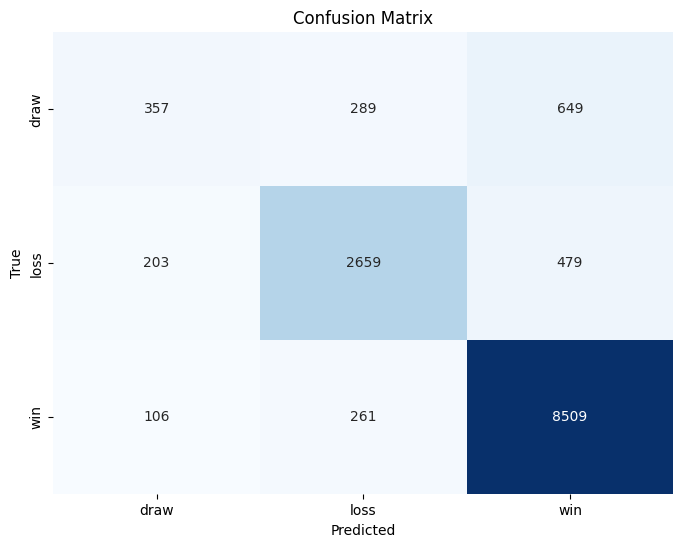

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(np.arange(3) + 0.5, ['draw', 'loss', 'win'])
plt.yticks(np.arange(3) + 0.5, ['draw', 'loss', 'win'])
plt.show()

# Balancing the training set

As we can see, the model is pretty good at predicting win or loss, but not so great at predicting draws. Another important thing to note, is that there are much fewer wins than any other class. Let's make another attempt at training the previous model, but let's train over a balanced dataset, with the hopes that our model will have more balanced accuracy and overall higher accuracy. To make a balanced dataset (one where each class has about equal representation), we will use undersampling.

In [ ]:
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import fetch_openml

connect_4 = fetch_ucirepo(id=26)

X = connect_4.data.features
y = connect_4.data.targets

feature_encoder = OneHotEncoder()
X_encoded = feature_encoder.fit_transform(X).toarray()

label_encoder = OneHotEncoder(sparse_output=False)
y_encoded = label_encoder.fit_transform(y.to_numpy().reshape(-1, 1))

X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

def get_label_distribution(labels):
    label_counts = labels.sum(axis=0)
    return dict(zip(label_encoder.categories_[0], label_counts))

print(f'Original label distribution: {get_label_distribution(y_train)}')
print(f'Resampled label distribution: {get_label_distribution(y_train_res)}')


Original label distribution: {'draw': 5154.0, 'loss': 13294.0, 'win': 35597.0}
Resampled label distribution: {'draw': 5154, 'loss': 5154, 'win': 5154}


# Increase epochs

Let's train for 100 epochs, and see if our model will give us the results we want.

In [ ]:
fit_model(model, X_train_res, y_train_res, X_test, y_test, 100)

Epoch 1/100
241/242 [============================>.] - ETA: 0s - loss: 0.6551 - accuracy: 0.7270
Epoch 1: val_accuracy improved from -inf to 0.75851, saving model to model.keras
242/242 [==============================] - 6s 10ms/step - loss: 0.6546 - accuracy: 0.7272 - val_loss: 0.5287 - val_accuracy: 0.7585
Epoch 2/100
235/242 [============================>.] - ETA: 0s - loss: 0.5774 - accuracy: 0.7515
Epoch 2: val_accuracy improved from 0.75851 to 0.77383, saving model to model.keras
242/242 [==============================] - 2s 9ms/step - loss: 0.5780 - accuracy: 0.7510 - val_loss: 0.5030 - val_accuracy: 0.7738
Epoch 3/100
242/242 [==============================] - ETA: 0s - loss: 0.5544 - accuracy: 0.7605
Epoch 3: val_accuracy did not improve from 0.77383
242/242 [==============================] - 2s 8ms/step - loss: 0.5544 - accuracy: 0.7605 - val_loss: 0.5499 - val_accuracy: 0.7597
Epoch 4/100
241/242 [============================>.] - ETA: 0s - loss: 0.5536 - accuracy: 0.7593
Ep

423/423 [==============================] - 1s 2ms/step


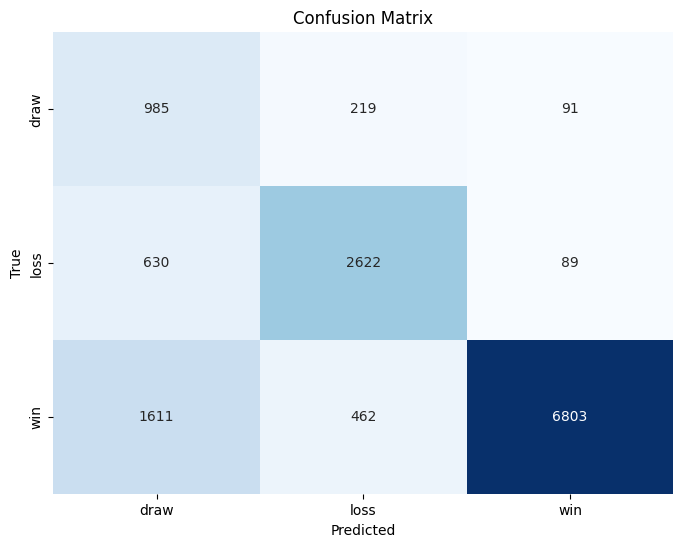

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(np.arange(3) + 0.5, ['draw', 'loss', 'win'])
plt.yticks(np.arange(3) + 0.5, ['draw', 'loss', 'win'])
plt.show()

# Final thoughts

Now after training with a balanced dataset, we see that our balanced accuracy is around 80%, and it's clear that the model is fairly accurate at predicting wins and losses. However, the model is still challenged at predicting draws, with a tendency to classify draws as wins. Curiously, I wonder if it is possible to get a better accuracy over this data.

# Just for fun

Let's look at another dataset. The features of this dataset is the sequence of column choices in an incomplete game of connect 4, and this time the label is the 'scores' for each column.

# Reconstructing gameboard from move sequence
We would like to train using the gameboard as the features, so we will need to reconstruct the gameboards from the given move sequences in the new dataset.

In [137]:

def move_sequence_to_board_vector(sequence, rows=6, columns=7):
    board = np.zeros((rows, columns), dtype=int)
    player = 1
    if pd.notna(sequence):
        for move in str(sequence):
            move = int(move) - 1
            for row in range(rows - 1, -1, -1):
                if board[row, move] == 0:
                    board[row, move] = player
                    break
            player *= -1
    return board

print('move_sequence -> board')
print(f'444 -> {move_sequence_to_board_vector(444)}')

move_sequence -> board
444 -> [[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0]
 [ 0  0  0 -1  0  0  0]
 [ 0  0  0  1  0  0  0]]


# Add some more features

Since we just want a model that plays connect 4 really well, let's add some features to our data to help the model learn more about the game. Lets calculate and include the following features:

- Number of open ended 3-in-a-rows for each player
- Number of two-in-a-rows
- number of pieces in center column
- distance (in moves) to win/lose state


In [138]:
def count_open_ended_three_in_a_rows(board, player):
    count = 0
    for i in range(4):
        for j in range(7):
            if board[i, j] == player:
                count += 1
    return count

def count_open_ended_two_in_a_rows(board, player):
    count = 0
    for i in range(5):
        for j in range(7):
            if board[i, j] == player:
                count += 1
    return count

def count_pieces_in_center_column(board, player):
    count = 0
    for i in range(6):
        if board[i, 3] == player:
            count += 1
    return count



# About the dataset
We generated this dataset by using the following connect 4 solver: https://github.com/PascalPons/connect4. There are two datasets. One dataset is comprised of 1000 games where both players play with perfect strategy (moves selected by minimax algorithm). The other dataset is comprised of 1000 games where players make their moves randomly.

In [139]:
perfect_strat_data_path = 'perfect_strategy.csv'
no_strat_data_path = 'no_strategy.csv'
column_names = ['game_id', 'move_sequence'] + ['col_' + str(i) for i in range(1, 8)]
perfect_strat_data = pd.read_csv(perfect_strat_data_path, header=None, names=column_names)
no_strat_data = pd.read_csv(no_strat_data_path, header=None, names=column_names)

The move sequence should be a string, not a number.

In [140]:
# lets change the dtype of the move_sequence column to str, and anything that is currently NaN will be empty str ''
perfect_strat_data['move_sequence'] = perfect_strat_data['move_sequence'].astype(str)
no_strat_data['move_sequence'] = no_strat_data['move_sequence'].astype(str)
perfect_strat_data['move_sequence'] = perfect_strat_data['move_sequence'].replace('nan', '')
no_strat_data['move_sequence'] = no_strat_data['move_sequence'].replace('nan', '')

The data contains examples from two players in many games of connect 4. Let's train the model to be player 1, by using all the examples in which the sequence has an even length.

In [141]:
perfect_strat_data = perfect_strat_data[perfect_strat_data['move_sequence'].str.len() % 2 == 0]
no_strat_data = no_strat_data[no_strat_data['move_sequence'].str.len() % 2 == 0]

In [142]:
perfect_strat_data.head()

,game_id,move_sequence,col_1,col_2,col_3,col_4,col_5,col_6,col_7
0,0,,-2,-1,0,1,0,-1,-2
2,0,44,-3,-3,-2,1,-2,-3,-3
4,0,4444,-2,-2,-2,1,-2,-2,-2
6,0,444443,-2,-3,1,-3,-3,1,-2
8,0,44444367,-13,-13,1,-14,-15,1,-3


In [143]:
no_strat_data.head()

,game_id,move_sequence,col_1,col_2,col_3,col_4,col_5,col_6,col_7
0,0,,-2,-1,0,1,0,-1,-2
2,0,27,-1,3,0,3,0,-2,-1
4,0,2722,-3,0,2,3,0,-2,0
6,0,272261,-2,0,0,-2,0,-2,-2
8,0,27226144,-5,-5,-3,-2,-3,-4,-4


# What do the column scores mean?
The scores in columns 1-7 represent the winning piece, under the assumption that both sides will complete the game using perfect strategy. Assume that it is our turn to play. If a column has a score of *1*, we will win with our *last* piece if we play that column. If a column has a score of *-2* and we play that column, our opponent will win with their *second-to-last* piece, and so on. Thus, the optimal column would be the column with the most positive score.

For the classifier, we will prepare a feature matrix composed of the states of the game board, reconstructed from the sequence of game moves. The labels will be the column index, {1-7}, of the column with the most positive score. The model will recieve a game board, and predict the best column to play next.

In [144]:
def get_features(sequence):
    board = move_sequence_to_board_vector(sequence)
    return np.array(list(board.flatten())
    + [count_open_ended_three_in_a_rows(board, 1),
       count_open_ended_two_in_a_rows(board, 1),
       count_pieces_in_center_column(board, 1),
       count_open_ended_three_in_a_rows(board, -1),
       count_open_ended_two_in_a_rows(board, -1),
       count_pieces_in_center_column(board, -1)])

# Accepting multiple answers

Since there are times when multiple columns have the max score, so we need to think about that when we are evaluating the accuracy of our model. We will have a label matrix for training, and a label matrix for evaluation.

In [145]:
import numpy as np
from sklearn.model_selection import train_test_split

def encode_single_best(scores):
    return np.argmax(scores, axis=1)

def encode_multi_correct(scores):
    max_score = np.max(scores, axis=1, keepdims=True)
    return (scores == max_score).astype(int)

X_perfect = np.array([get_features(sequence) for sequence in perfect_strat_data['move_sequence']])
X_no_strat = np.array([get_features(sequence) for sequence in no_strat_data['move_sequence']])

y_perfect_single = encode_single_best(perfect_strat_data.iloc[:, 2:].values)
y_no_strat_single = encode_single_best(no_strat_data.iloc[:, 2:9].values)

y_perfect_multi = encode_multi_correct(perfect_strat_data.iloc[:, 2:9].values)
y_no_strat_multi = encode_multi_correct(no_strat_data.iloc[:, 2:9].values)

X_perfect_train, X_perfect_test, y_perfect_train, y_perfect_test = train_test_split(X_perfect, y_perfect_single, test_size=0.2, random_state=42)
X_no_strat_train, X_no_strat_test, y_no_strat_train, y_no_strat_test = train_test_split(X_no_strat, y_no_strat_single, test_size=0.2, random_state=42)

print("Features")
print(X_perfect_train[0])
print(X_no_strat_train[0])
print()

print("Training Labels")
print(y_perfect_train[0])
print(y_no_strat_train[0])
print()

print("Testing Labels")
print(y_perfect_multi[0])
print(y_no_strat_multi[0])


Features
[ 0 -1  1 -1  0 -1  0  0  1  1  1  0 -1  0  0  1 -1 -1  0  1  0  0 -1  1
  1 -1 -1  0  0  1 -1 -1  1  1 -1 -1  1 -1  1  1 -1  1  8 11  3  9 12  3]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0 -1  0  0  0  0  0  0  0]

Training Labels
0
1

Testing Labels
[0 0 0 1 0 0 0]
[0 0 0 1 0 0 0]


# Build the model

Building a simple model with 42 inputs, and 7 outputs, each for a column of the game board.

In [146]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_perfect_train.shape[1],)),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_132 (Dense)           (None, 128)               6272      
                                                                 
 dense_133 (Dense)           (None, 128)               16512     
                                                                 
 dense_134 (Dense)           (None, 7)                 903       
                                                                 
Total params: 23687 (92.53 KB)
Trainable params: 23687 (92.53 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Perfect strategy

Let's see how the model does with the perfect strategy data.

In [147]:
model.fit(X_perfect_train, y_perfect_train, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10
473/473 [==============================] - 2s 3ms/step - loss: 1.1898 - accuracy: 0.5880 - val_loss: 0.9726 - val_accuracy: 0.6583
Epoch 2/10
473/473 [==============================] - 1s 3ms/step - loss: 0.8826 - accuracy: 0.6899 - val_loss: 0.8769 - val_accuracy: 0.6863
Epoch 3/10
473/473 [==============================] - 1s 3ms/step - loss: 0.7716 - accuracy: 0.7315 - val_loss: 0.7480 - val_accuracy: 0.7417
Epoch 4/10
473/473 [==============================] - 1s 3ms/step - loss: 0.6918 - accuracy: 0.7606 - val_loss: 0.7162 - val_accuracy: 0.7488
Epoch 5/10
473/473 [==============================] - 1s 3ms/step - loss: 0.6337 - accuracy: 0.7840 - val_loss: 0.6716 - val_accuracy: 0.7810
Epoch 6/10
473/473 [==============================] - 1s 3ms/step - loss: 0.5727 - accuracy: 0.8086 - val_loss: 0.6326 - val_accuracy: 0.7887
Epoch 7/10
473/473 [==============================] - 1s 3ms/step - loss: 0.5238 - accuracy: 0.8235 - val_loss: 0.5883 - val_accuracy: 0.8125
Epoch 

In [148]:
def custom_accuracy(y_true, y_pred_indices):
    correct_count = 0
    for i, pred_index in enumerate(y_pred_indices):
        if y_true[i, pred_index] == 1:
            correct_count += 1
    return correct_count / len(y_pred_indices)

y_pred_proba = model.predict(X_perfect_test)
y_pred_indices = np.argmax(y_pred_proba, axis=1)

y_perfect_multi_test = train_test_split(y_perfect_multi, test_size=0.2, random_state=42)[1]
print("Custom Test Accuracy:", custom_accuracy(y_perfect_multi_test, y_pred_indices))


132/132 [==============================] - 0s 1ms/step
Custom Test Accuracy: 0.8757142857142857


# No strategy

And now the no strategy data.

In [149]:
model.fit(X_no_strat_train, y_no_strat_train, epochs=10, batch_size=32, validation_split=0.1)

y_pred_proba = model.predict(X_no_strat_test)
y_pred_indices = np.argmax(y_pred_proba, axis=1)

y_no_strat_multi_test = train_test_split(y_no_strat_multi, test_size=0.2, random_state=42)[1]
print("Custom Test Accuracy:", custom_accuracy(y_no_strat_multi_test, y_pred_indices))

Epoch 1/10
245/245 [==============================] - 1s 3ms/step - loss: 1.7335 - accuracy: 0.3702 - val_loss: 1.4642 - val_accuracy: 0.4108
Epoch 2/10
245/245 [==============================] - 1s 3ms/step - loss: 1.3949 - accuracy: 0.4658 - val_loss: 1.3647 - val_accuracy: 0.4822
Epoch 3/10
245/245 [==============================] - 1s 3ms/step - loss: 1.2920 - accuracy: 0.5199 - val_loss: 1.2890 - val_accuracy: 0.5201
Epoch 4/10
245/245 [==============================] - 1s 3ms/step - loss: 1.2051 - accuracy: 0.5603 - val_loss: 1.2425 - val_accuracy: 0.5443
Epoch 5/10
245/245 [==============================] - 1s 3ms/step - loss: 1.1261 - accuracy: 0.5926 - val_loss: 1.1978 - val_accuracy: 0.5489
Epoch 6/10
245/245 [==============================] - 1s 3ms/step - loss: 1.0635 - accuracy: 0.6105 - val_loss: 1.1860 - val_accuracy: 0.5662
Epoch 7/10
245/245 [==============================] - 1s 3ms/step - loss: 1.0077 - accuracy: 0.6390 - val_loss: 1.1497 - val_accuracy: 0.5765
Epoch 

# A mix of each

Training over the datasets combined.

In [150]:
X_combined_train = np.vstack((X_perfect_train, X_no_strat_train))
y_combined_train = np.hstack((y_perfect_train, y_no_strat_train))

X_combined_test = np.vstack((X_perfect_test, X_no_strat_test))
y_combined_test = np.hstack((y_perfect_test, y_no_strat_test))

y_combined_multi = np.vstack((y_perfect_multi, y_no_strat_multi))

In [151]:
model.fit(X_combined_train, y_combined_train, epochs=10, batch_size=32, validation_split=0.1)

y_pred_proba = model.predict(X_combined_test)
y_pred_indices = np.argmax(y_pred_proba, axis=1)

y_combined_multi_test = train_test_split(y_combined_multi, test_size=0.2, random_state=42)[1]
print("Custom Test Accuracy:", custom_accuracy(y_combined_multi_test, y_pred_indices))

Epoch 1/10
717/717 [==============================] - 2s 3ms/step - loss: 0.7276 - accuracy: 0.7481 - val_loss: 1.0270 - val_accuracy: 0.6238
Epoch 2/10
717/717 [==============================] - 2s 3ms/step - loss: 0.5869 - accuracy: 0.7966 - val_loss: 1.0288 - val_accuracy: 0.6293
Epoch 3/10
717/717 [==============================] - 2s 3ms/step - loss: 0.5382 - accuracy: 0.8150 - val_loss: 1.0355 - val_accuracy: 0.6273
Epoch 4/10
717/717 [==============================] - 2s 3ms/step - loss: 0.5025 - accuracy: 0.8282 - val_loss: 1.0454 - val_accuracy: 0.6285
Epoch 5/10
717/717 [==============================] - 2s 3ms/step - loss: 0.4728 - accuracy: 0.8370 - val_loss: 1.0669 - val_accuracy: 0.6242
Epoch 6/10
717/717 [==============================] - 2s 3ms/step - loss: 0.4514 - accuracy: 0.8443 - val_loss: 1.0673 - val_accuracy: 0.6191
Epoch 7/10
717/717 [==============================] - 2s 3ms/step - loss: 0.4263 - accuracy: 0.8536 - val_loss: 1.0689 - val_accuracy: 0.6352
Epoch 

We can see the model best learned the perfect strategy data, worst learned the random play data, and predictably performed somewhere in the middle on the combined data.

Lets see if we can do even better on the perfect strategy data. Just for fun, let's add more layers and increase the epochs. We will add a checkpoint callback, which will save the best model in a keras file for us.

In [152]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(48,)),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_135 (Dense)           (None, 128)               6272      
                                                                 
 dense_136 (Dense)           (None, 256)               33024     
                                                                 
 dense_137 (Dense)           (None, 256)               65792     
                                                                 
 dense_138 (Dense)           (None, 512)               131584    
                                                                 
 dense_139 (Dense)           (None, 1024)              525312    
                                                                 
 dense_140 (Dense)           (None, 2048)              2099200   
                                                                 
 dense_141 (Dense)           (None, 1024)            

In [153]:
checkpoint_path = 'connect_4_board_classifier.keras'
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

model.fit(X_perfect_train, y_perfect_train, epochs=100, batch_size=64,
          validation_split=0.1, callbacks=[checkpoint])

y_pred_proba = model.predict(X_perfect_test)
y_pred_indices = np.argmax(y_pred_proba, axis=1)

y_perfect_multi_test = train_test_split(y_perfect_multi, test_size=0.2, random_state=42)[1]
print("Custom Test Accuracy:", custom_accuracy(y_perfect_multi_test, y_pred_indices))

Epoch 1/100
228/237 [===========================>..] - ETA: 0s - loss: 1.3573 - accuracy: 0.4934
Epoch 1: val_loss improved from inf to 1.22393, saving model to connect_4_board_classifier.keras
237/237 [==============================] - 5s 7ms/step - loss: 1.3495 - accuracy: 0.4962 - val_loss: 1.2239 - val_accuracy: 0.5304
Epoch 2/100
229/237 [===========================>..] - ETA: 0s - loss: 1.1164 - accuracy: 0.5907
Epoch 2: val_loss improved from 1.22393 to 1.04885, saving model to connect_4_board_classifier.keras
237/237 [==============================] - 1s 6ms/step - loss: 1.1125 - accuracy: 0.5919 - val_loss: 1.0488 - val_accuracy: 0.6256
Epoch 3/100
229/237 [===========================>..] - ETA: 0s - loss: 0.9824 - accuracy: 0.6513
Epoch 3: val_loss did not improve from 1.04885
237/237 [==============================] - 1s 5ms/step - loss: 0.9791 - accuracy: 0.6521 - val_loss: 1.0709 - val_accuracy: 0.6536
Epoch 4/100
226/237 [===========================>..] - ETA: 0s - loss: 

132/132 [==============================] - 0s 2ms/step


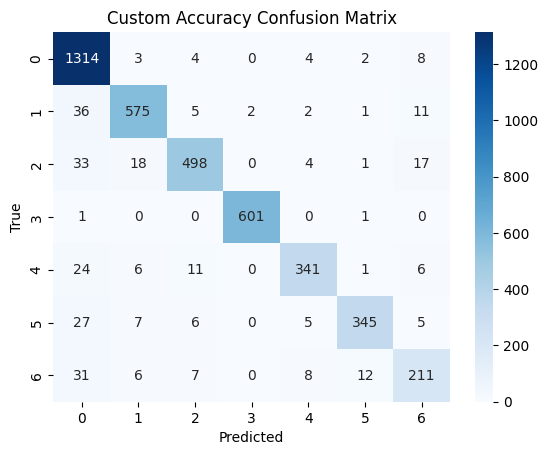

In [180]:
def multi_label_confusion_matrix(y_true_multi, y_pred_classes, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true, pred in zip(y_true_multi, y_pred_classes):
        true_indices = np.where(true == 1)[0]
        true_index = np.argmax(true)
        if pred in true_indices:
            true_index = pred
        cm[true_index, pred] += 1
    return cm

y_pred = model.predict(X_perfect_test)
y_pred_classes = np.argmax(y_pred, axis=1)
num_classes = y_perfect_multi_test.shape[1]

cm = multi_label_confusion_matrix(y_perfect_multi_test, y_pred_classes, num_classes)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Custom Accuracy Confusion Matrix')
plt.show()

# Can it play?

As one might imagine, using this model to play an entire game is as straight-forward as predicting each move until the game is complete. Putting our model up against something that uses minimax or Monte Carlo tree search (like the program used to generate this last dataset) would be pointless because we know our model stands no chance at all. However, how would it perform against a more imperfect opponent, like a human?

## Not really

After playing just a few games, one quickly realizes that the model lacks the ability to recognize critical moves, where a move leads to a win or a loss. The model is not trained to make a winning move, just a pretty good move. So let's try one more thing.

# Convolutional NN

In [190]:
import numpy as np
from sklearn.model_selection import train_test_split

def encode_single_best(scores):
    return np.argmax(scores, axis=1)

def encode_multi_correct(scores):
    max_score = np.max(scores, axis=1, keepdims=True)
    return (scores == max_score).astype(int)

X_perfect = np.array([move_sequence_to_board_vector(sequence) for sequence in perfect_strat_data['move_sequence']])
y_perfect_single = encode_single_best(perfect_strat_data.iloc[:, 2:].values)
y_perfect_multi = encode_multi_correct(perfect_strat_data.iloc[:, 2:9].values)

X_perfect_train, X_perfect_test, y_perfect_train, y_perfect_test = train_test_split(X_perfect, y_perfect_single, test_size=0.2, random_state=42)

print("Features")
print(X_perfect_train[0])
print()

print("Training Labels")
print(y_perfect_train[0])
print()

print("Testing Labels")
print(y_perfect_multi[0])


Features
[[ 0 -1  1 -1  0 -1  0]
 [ 0  1  1  1  0 -1  0]
 [ 0  1 -1 -1  0  1  0]
 [ 0 -1  1  1 -1 -1  0]
 [ 0  1 -1 -1  1  1 -1]
 [-1  1 -1  1  1 -1  1]]

Training Labels
0

Testing Labels
[0 0 0 1 0 0 0]


In [195]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(6, 7, 1)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(512, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(2048, activation='relu'),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 6, 7, 32)          320       
                                                                 
 conv2d_21 (Conv2D)          (None, 6, 7, 64)          18496     
                                                                 
 conv2d_22 (Conv2D)          (None, 6, 7, 128)         73856     
                                                                 
 flatten_7 (Flatten)         (None, 5376)              0         
                                                                 
 dense_192 (Dense)           (None, 128)               688256    
                                                                 
 dense_193 (Dense)           (None, 256)               33024     
                                                                 
 dense_194 (Dense)           (None, 512)             

In [196]:
checkpoint_path = 'connect_4_board_classifier.keras'
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1)

model.fit(X_perfect_train, y_perfect_train, epochs=200, batch_size=64,
          validation_split=0.1, callbacks=[checkpoint])

y_pred_proba = model.predict(X_perfect_test)
y_pred_indices = np.argmax(y_pred_proba, axis=1)

y_perfect_multi_test = train_test_split(y_perfect_multi, test_size=0.2, random_state=42)[1]
print("Custom Test Accuracy:", custom_accuracy(y_perfect_multi_test, y_pred_indices))

Epoch 1/200
237/237 [==============================] - ETA: 0s - loss: 1.4636 - accuracy: 0.4464
Epoch 1: val_loss improved from inf to 1.37744, saving model to connect_4_board_classifier.keras
237/237 [==============================] - 5s 9ms/step - loss: 1.4636 - accuracy: 0.4464 - val_loss: 1.3774 - val_accuracy: 0.4554
Epoch 2/200
229/237 [===========================>..] - ETA: 0s - loss: 1.1992 - accuracy: 0.5464
Epoch 2: val_loss improved from 1.37744 to 1.08313, saving model to connect_4_board_classifier.keras
237/237 [==============================] - 2s 7ms/step - loss: 1.1947 - accuracy: 0.5490 - val_loss: 1.0831 - val_accuracy: 0.6095
Epoch 3/200
229/237 [===========================>..] - ETA: 0s - loss: 0.9867 - accuracy: 0.6320
Epoch 3: val_loss improved from 1.08313 to 0.99678, saving model to connect_4_board_classifier.keras
237/237 [==============================] - 2s 7ms/step - loss: 0.9823 - accuracy: 0.6337 - val_loss: 0.9968 - val_accuracy: 0.6601
Epoch 4/200
230/2

132/132 [==============================] - 0s 2ms/step


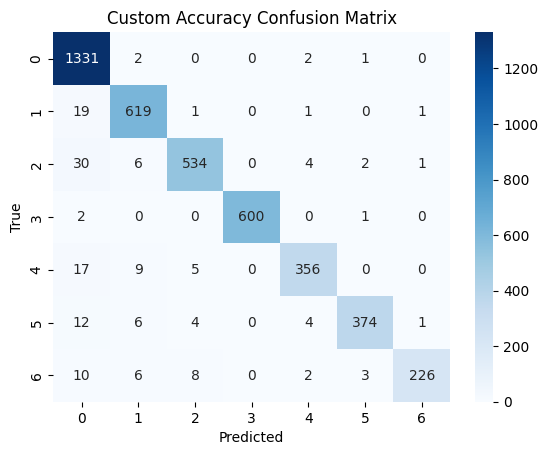

In [197]:
def multi_label_confusion_matrix(y_true_multi, y_pred_classes, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for true, pred in zip(y_true_multi, y_pred_classes):
        true_indices = np.where(true == 1)[0]
        true_index = np.argmax(true)
        if pred in true_indices:
            true_index = pred
        cm[true_index, pred] += 1
    return cm

y_pred = model.predict(X_perfect_test)
y_pred_classes = np.argmax(y_pred, axis=1)
num_classes = y_perfect_multi_test.shape[1]

cm = multi_label_confusion_matrix(y_perfect_multi_test, y_pred_classes, num_classes)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Custom Accuracy Confusion Matrix')
plt.show()